# Анализ лояльности пользователей Яндекс Афиши с помощью Python

**Автор:** Илья Иванов  
**Дата:** 11.11.2025  

---

## Цель исследования

Провести комплексный анализ поведения пользователей Яндекс Афиши для выявления ключевых факторов, влияющих на повторные покупки, с целью разработки эффективной стратегии удержания клиентов и оптимизации маркетинговых активностей.

## Задачи исследования:

1. **Идентифицировать профили лояльных пользователей** - определить характеристики пользователей, которые с наибольшей вероятностью возвращаются на платформу и совершают повторные заказы

2. **Проанализировать влияние характеристик первого заказа** на вероятность возврата пользователей, включая:
   - Тип мероприятия
   - Устройство покупки
   - Географическую принадлежность
   - Билетного оператора

3. **Исследовать поведенческие паттерны**, связанные с лояльностью:
   - Ценовые предпочтения и средний чек
   - Количество билетов в заказе
   - Временные характеристики покупок
   - Частоту и интервалы между заказами

4. **Определить корреляционные зависимости** между характеристиками пользователей и их лояльностью для построения прогнозных моделей

## Описание данных

**Выгрузка из базы данных `data-analyst-afisha`** содержит информацию о покупках билетов пользователями Яндекс Афиши:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (mobile — мобильные устройства, desktop — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа;
- `order_ts` — дата и время создания заказа;
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `event_name` — название мероприятия;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `service_name` — название билетного оператора;
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие;
- `revenue_rub` — выручка от заказа в российских рублях (расчетное поле).

**Дополнительные данные:**

**Файл `final_tickets_tenge_df.csv`** содержит информацию о курсе казахстанского тенге по отношению к российскому рублю за 2024 год:
- `data` — дата;
- `nominal` — номинал (всегда 100 тенге);
- `curs` — курс 100 тенге в рублях;
- `cdx` — код валюты (всегда kzt).

## Содержание

### 1. Загрузка данных
1.1. Выгрузка данных в датафрейм pandas необходимых данных  
1.2. Общая информация о выгруженных данных. Корректность выгрузки и объёма полученных данных  

### 2. Предобработка данных
2.1. Приведение выручки к единой валюте  
2.2. Проверка данных с учетом конвертации валют  
2.3. Преобразование типов данных  
2.4. Проверка номинальных и численных данных  

### 3. Создание профиля пользователя
3.1. Профиль пользователя  
3.2. Анализ репрезентативности данных  

### 4. Исследовательский анализ данных
4.1. Исследование признаков первого заказа и их связи с возвращением на платформу  
4.1.1. Распределение пользователей по признакам  
4.1.2. Возвраты пользователей  
4.1.3. Проверка продуктовых гипотез  

4.2. Исследование поведения пользователей через показатели выручки и состава заказа  
4.2.1. Связь между средней выручкой сервиса с заказа и повторными заказами  
4.2.2. Сравнение распределения по средней выручке в группах пользователей  
4.2.3. Анализ влияния среднего количества билетов в заказе на вероятность повторной покупки  

4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки  
4.3.1. Анализ влияния дня недели первой покупки  
4.3.2. Изучение влияния среднего интервала между заказами на удержание клиентов  

4.4. Корреляционный анализ количества покупок и признаков пользователя  
4.4.1. Корреляционный анализ с использованием универсального коэффициента корреляции phi_k  

### 5. Общие выводы и рекомендации

## Содержание

# 1. Загрузка данных

## 1.1. Выгрузка данных в датафрейм pandas необходимых данных.

Импортируем необходимые библиотеки для работы с данными и подключения к базе данных.

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

Зададим параметры подключения к базе данных.

In [2]:
load_dotenv()

True

In [3]:
db_config = {
    'user': os.getenv('DB_USER'),           # имя пользователя
    'pwd': os.getenv('DB_PASSWORD'),        # пароль
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),           # порт подключения
    'db': os.getenv('DB_NAME')              # название базы данных
}

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string)

Сформируем SQL-запрос для выгрузки данных о покупках, мероприятиях и географии пользователей, включая расчет дней между заказами.

In [6]:
query = '''
SELECT 
  p.user_id,
  p.device_type_canonical,
  p.order_id::INTEGER AS order_id,
  p.created_dt_msk AS order_dt,
  p.created_ts_msk AS order_ts,
  p.currency_code,
  p.revenue,
  p.tickets_count,
  CASE 
    WHEN LAG(p.created_dt_msk) OVER (
      PARTITION BY p.user_id 
      ORDER BY p.created_dt_msk
    ) IS NOT NULL 
    THEN EXTRACT(DAY FROM (p.created_dt_msk - LAG(p.created_dt_msk) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
      )))::INTEGER
    ELSE NULL
  END AS days_since_prev,
  p.event_id,
  e.event_name_code AS event_name,
  e.event_type_main,
  p.service_name,
  r.region_name,
  c.city_name
FROM afisha.purchases p
INNER JOIN afisha.events e ON p.event_id = e.event_id
LEFT JOIN afisha.city c ON e.city_id = c.city_id
LEFT JOIN afisha.regions r ON c.region_id = r.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop')
  AND e.event_type_main != 'фильм'
ORDER BY p.user_id
--LIMIT 10;
'''

Загрузим результаты в DataFrame для последующего анализа.

In [7]:
df = pd.read_sql_query(query, con=engine)

## 1.2. Общая информацию о выгруженных данных. Корректность выгрузки и объёма полученных данных.

Для первичного анализа структуры и качества данных применим следующий набор стандартных методов:

- **`info()`** — общая информация о типах данных и объёме датафрейма  
- **`head()`** — просмотр первых строк для понимания общей структуры  
- **`isna().sum()` и `isna().mean()`** — выявление пропущенных значений в абсолютном и относительном выражении  
- **`describe()`** — основные статистики числовых переменных (среднее, медиана, разброс и т.д.)  
- **`duplicated().sum()`** — проверка на наличие полных дубликатов записей  
- **Анализ уникальных значений категориальных признаков** — для оценки разнообразия и выявления потенциальных аномалий (например, опечаток, редких категорий)

Для удобства и повторного использования соберём все шаги в **универсальную функцию**, которая будет автоматически проводить полный экспресс-анализ любого датафрейма.

In [8]:
def explore_data(df):
    # Базовая информация
    print("Базовая информация:")
    df.info()
    print()
    
    # Первые строки
    print("Первые 10 строк:")
    print(df.head(10))
    print()
    
    # Пропуски
    missing = pd.DataFrame({
        'абс.': df.isna().sum(),
        'отн.': (df.isna().mean() * 100).round(1)
    })
    missing = missing[missing['абс.'] > 0].sort_values('абс.', ascending=False)
    
    if len(missing) > 0:
        print("Пропущенные значения:")
        print(missing)
        print()
    
    # Числовые данные
    numeric = df.select_dtypes(include='number')
    if not numeric.empty:
        print("Описательная статистика:")
        print(numeric.describe().round(2))
        print()
    
    # Дубликаты
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"Дубликаты: {duplicates}")
    else:
        print("Дубликаты: 0")
    print()
    
    # Категориальные данные
    categorical = df.select_dtypes(include=['object', 'category'])
    if not categorical.empty:
        print("Категориальные переменные:")
        for col in categorical.columns:
            print(f"{col}: {df[col].nunique()} уникальных значений")
        print()

# Используем функцию для анализа данных
explore_data(df)

Базовая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           2

**Краткий вывод по результатам первичного анализа:**

Данные успешно выгружены - получен датафрейм из 290,611 записей с 15 столбцами. Качество данных высокое: отсутствуют дубликаты и пропуски, кроме ожидаемых 21,933 пропусков в days_since_prev (7.5%), которые соответствуют первым покупкам пользователей. 

**Ключевые наблюдения:**
- Охвачен период из 5 месяцев активности платформы
- 21,933 уникальных пользователя с высокой частотой повторных действий (медиана days_since_prev = 0)
- Широкая география: 81 регион, 352 города
- Разнообразие мероприятий: 7 основных типов, 15,248 уникальных событий
- 36 билетных операторов с разной долей рынка

Данные хорошо структурированы и готовы к дальнейшей предобработке и анализу.

Проверим полноту выгруженных данных, убедившись, что все необходимые для анализа поля присутствуют в датафрейме.

In [9]:
required_columns = [
    'user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
    'currency_code', 'revenue', 'tickets_count', 'days_since_prev',
    'event_id', 'event_name', 'event_type_main', 'service_name', 
    'region_name', 'city_name'
]
print("Все поля присутствуют:", all(col in df.columns for col in required_columns))
print("Отсутствующие поля:", [col for col in required_columns if col not in df.columns])

Все поля присутствуют: True
Отсутствующие поля: []


Отсутствующих полей не обнаружено, что подтверждает корректность формирования запроса и выгрузки данных.

Проверим временной охват выгруженных данных для подтверждения корректности фильтрации по периоду в SQL-запросе.

In [10]:
print(f"Минимальная дата: {df['order_dt'].min()}")
print(f"Максимальная дата: {df['order_dt'].max()}")
date_range = (df['order_dt'].max() - df['order_dt'].min()).days
print(f"Период покрытия: {date_range} дней (~{date_range//30} месяцев)")

Минимальная дата: 2024-06-01 00:00:00
Максимальная дата: 2024-10-31 00:00:00
Период покрытия: 152 дней (~5 месяцев)


Период соответствует ожидаемой выгрузке.

Проверим корректность расчета days_since_prev в SQL-запросе, сопоставив записи с пропусками с вычисленными первыми покупками пользователей.

In [11]:
user_first_purchases = df.groupby('user_id')['order_dt'].min().reset_index()
user_first_purchases['is_first'] = True
df_with_first = df.merge(user_first_purchases, on=['user_id', 'order_dt'], how='left')
first_purchase_nulls = df_with_first[df_with_first['is_first'] == True]['days_since_prev'].isna().sum()
print(f"Пропуски на первых покупках: {first_purchase_nulls:,}")
print(f"Совпадение: {first_purchase_nulls == df['days_since_prev'].isna().sum()}")

Пропуски на первых покупках: 21,933
Совпадение: True


Все пропуски в days_since_prev соответствуют первым покупкам пользователей

Проверим, что пропуски соответствуют первым покупкам

In [12]:
print(f"Всего записей: {len(df):,}")
print(f"Пропуски в days_since_prev: {df['days_since_prev'].isna().sum():,}")
print(f"Заполненные значения: {df['days_since_prev'].notna().sum():,}")

Всего записей: 290,611
Пропуски в days_since_prev: 21,933
Заполненные значения: 268,678


Количество пропусков в days_since_prev (21,933) точно соответствует количеству первых покупок, а заполненные значения (268,678) - повторным заказам. Это подтверждает, что оконная функция в SQL-запросе корректно вычислила интервалы между покупками для каждого пользователя.

Проверим JOIN (пропуски в region_name, city_name)

In [13]:
print(f"Пропуски в region_name: {df['region_name'].isna().sum()}")
print(f"Пропуски в city_name: {df['city_name'].isna().sum()}")

Пропуски в region_name: 0
Пропуски в city_name: 0


Отсутствие пропусков в полях region_name и city_name подтверждает корректность LEFT JOIN операций с таблицами городов и регионов в SQL-запросе. Все записи содержат географическую привязку.

Проверим корректность применения фильтров в SQL-запросе, проанализировав уникальные значения в ключевых категориальных полях.

In [14]:
print("Типы устройств:", df['device_type_canonical'].unique())
print("Типы мероприятий:", df['event_type_main'].unique())
print("Наличие фильмов:", 'фильм' in df['event_type_main'].values)

Типы устройств: ['mobile' 'desktop']
Типы мероприятий: ['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
Наличие фильмов: False


Проверка подтверждает, что все условия WHERE отработали правильно:
- В данных присутствуют только 'mobile' и 'desktop' устройства
- Категория 'фильм' отсутствует в типах мероприятий
- Сохранены 7 актуальных типов мероприятий для анализа

Проверим выполнение условия сортировки, указанного в SQL-запросе (ORDER BY p.user_id), проанализировав порядок записей для выборки пользователей.

In [15]:
# Проверим несколько пользователей
sample_users = df['user_id'].head(100).unique()
is_sorted = all(
    df[df['user_id'] == user]['order_dt'].is_monotonic_increasing 
    for user in sample_users
)
print("Данные отсортированы по user_id и order_dt:", is_sorted)

Данные отсортированы по user_id и order_dt: True


Данные отсортированы по user_id и order_dt в соответствии с указанным в запросе ORDER BY p.user_id. Это обеспечивает корректную работу оконных функций и последующий анализ последовательности покупок пользователей.

**Вывод по проверке корректности SQL-выгрузки**

Все проведенные проверки подтверждают полную корректность выполненной выгрузки данных:

1. **Полнота данных** - все 15 запрошенных полей присутствуют, отсутствующих полей нет
2. **Временной охват** - данные охватывают полные 5 месяцев (июнь-октябрь 2024)
3. **Качество данных** - отсутствуют дубликаты, пропуски только в days_since_prev (7.5%)
4. **Корректность расчетов** - все пропуски в days_since_prev соответствуют первым покупкам пользователей
5. **Географические данные** - все записи содержат полную географическую привязку (регион и город)
6. **Фильтрация** - условия WHERE применены корректно (только mobile/desktop, исключены фильмы)
7. **Сортировка** - данные отсортированы по user_id и order_dt как указано в запросе

Все поля соответствуют заявленному описанию, типы данных корректны, значения релевантны поставленным задачам анализа лояльности.

# 2. Предобработка данных

## 2.1. Приведение выручки к единой валюте.

Проанализируем распределение выручки по валютам для оценки объема данных, требующих конвертации в единую валюту.

In [16]:
# Сумма выручки в рублях и тенге
print("Сумма выручки по валютам:")
print(f"RUB: {df[df['currency_code'] == 'rub']['revenue'].sum():,.2f}")
print(f"KZT: {df[df['currency_code'] == 'kzt']['revenue'].sum():,.2f}")

Сумма выручки по валютам:
RUB: 156,480,993.39
KZT: 25,320,703.10


Значительная часть выручки требует конвертации в рубли.

Общая выручка составляет ~181.8 млн рублей, из которых 25.3 млн (13.9%) номинированы в тенге. Для корректного финансового анализа необходимо привести все значения к единой валюте (RUB) с использованием актуальных курсов.

Данные о курсе тенге по отношению к российскому рублю представлены в датасете final_tickets_tenge_df.csv.

In [17]:
# Загружаем данные о курсе тенге
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

Получим общую информацию о датасете final_tickets_tenge_df.csv с помощью ранее созданной функции для анализа данных explore_data()

In [18]:
explore_data(tenge_df)

Базовая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB

Первые 10 строк:
         data  nominal     curs  cdx
0  2024-01-10      100  19.9391  kzt
1  2024-01-11      100  19.7255  kzt
2  2024-01-12      100  19.5839  kzt
3  2024-01-13      100  19.4501  kzt
4  2024-01-14      100  19.4501  kzt
5  2024-01-15      100  19.4501  kzt
6  2024-01-16      100  19.4264  kzt
7  2024-01-17      100  19.4177  kzt
8  2024-01-18      100  19.5798  kzt
9  2024-01-19      100  19.5741  kzt

Описательная статистика:
       nominal    curs
count    357.0  357.00
mean     100.0   19.76
std        0.0    0.83
min      100.0   17.85
25%      100.0   19

Данные о курсах тенге полностью готовы к использованию.

Датасет с курсами валют содержит 357 записей за период с 10 января 2024 года. Данные качественные: отсутствуют пропуски и дубликаты, курс представлен для 100 тенге с минимальной вариацией (std=0.83). Все значения в колонке 'cdx' соответствуют 'kzt', что подтверждает корректность данных. Курсы можно безопасно использовать для конвертации выручки.

Объединим данные о покупках с курсами валют по датам и выполним конвертацию выручки из тенге в рубли по актуальным курсам, сохраняя рублевые значения без изменений.

In [19]:
# Преобразуем даты к единому формату
tenge_df['date'] = pd.to_datetime(tenge_df['data'])
df['order_date'] = pd.to_datetime(df['order_dt'].dt.date)

In [20]:
# Объединяем данные о покупках с курсами валют
df_merged = df.merge(
    tenge_df[['date', 'curs']], 
    left_on='order_date', 
    right_on='date', 
    how='left'
)

In [21]:
# Выполняем конвертацию
df_merged['revenue_rub'] = df_merged.apply(
    lambda x: (
        x['revenue'] if x['currency_code'] == 'rub'  # для рублей оставляем как есть
        else x['revenue'] * (x['curs'] / 100) if pd.notna(x['curs'])  # для тенге конвертируем
        else x['revenue']  # если курс отсутствует
    ), 
    axis=1
)

Добавим в исходный датафрейм новый столбец `revenue_rub` с выручкой, приведенной к единой валюте (российский рубль), для последующего анализа.

In [22]:
# Добавляем столбец revenue_rub в исходный DataFrame
df['revenue_rub'] = df_merged['revenue_rub']

Проверим результаты конвертации

In [23]:
# Сумма выручки в рублях после преобразования
print(f"Общая выручка в RUB после конвертации: {df['revenue_rub'].sum():,.2f}")

Общая выручка в RUB после конвертации: 161,455,330.62


**Вывод: конвертация валют выполнена успешно**

После приведения всей выручки к российской валюте общая сумма составила 161.5 млн рублей. Конвертация 25.3 млн тенге по актуальным курсам увеличила рублевый эквивалент на ~5 млн рублей по сравнению с исходной рублевой выручкой, что подтверждает корректность проведенной операции.

Удалим временную колонку `order_date`, созданную для объединения с курсами валют, чтобы сохранить чистоту структуры исходного датафрейма.

In [24]:
# Удаляем временные колонки
df.drop('order_date', axis=1, inplace=True, errors='ignore')

### 2.2.1. Проверка данных с учетом конвертации валют

Проверка данных на пропущенные значения

In [25]:
explore_data(df)

Базовая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           2

**Вывод: данные успешно дополнены конвертированной выручкой**

Проверка после конвертации валют показывает:
- Добавлен новый столбец `revenue_rub` с выручкой в единой валюте
- Все 290,611 записей содержат значения в новом поле
- Структура данных сохранена, пропуски остались только в `days_since_prev` (7.5%)
- Статистики `revenue_rub` показывают схожее распределение с исходной выручкой

**Природа пропусков:** Пропуски в столбце `days_since_prev` являются MNAR (Missing Not At Random), так как они систематически обусловлены бизнес-логикой: отсутствие значения указывает на то, что запись соответствует первой покупке пользователя. Это ожидаемое и корректное поведение данных, не требующее заполнения пропусков.

Данные готовы к дальнейшей предобработке типов данных.

### Задача 2.2.2. Преобразование типов данных

Проверим текущие типы данных в датафрейме для определения необходимых преобразований при оптимизации.

In [26]:
df.dtypes

user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
revenue_rub                     float64
dtype: object

**Выявлены возможности для оптимизации типов данных**

Текущие типы данных показывают:

- Числовые поля (`order_id`, `tickets_count`, `event_id`) используют избыточные типы (int64)
- `days_since_prev` имеет тип float64, но содержит целочисленные значения
- Финансовые поля (`revenue`, `revenue_rub`) корректно сохранены как float64
- 8 полей типа `object` можно преобразовать в `category` для экономии памяти

Оптимизация типов данных позволит значительно сократить объем используемой памяти.

Оптимизируем тип данных для `order_id`, преобразовав из int64 в int32, что достаточно для хранения идентификаторов заказов и экономит память.

In [27]:
# order_id - можно использовать int32 вместо int64
df['order_id'] = df['order_id'].astype('int32')
print(f"order_id: {df['order_id'].dtype}")

order_id: int32


Преобразуем `tickets_count` в тип int8, так как количество билетов представляет собой небольшие целые числа, что позволяет значительно сократить использование памяти.

In [28]:
# tickets_count - маленькие числа, можно использовать int8
df['tickets_count'] = df['tickets_count'].astype('int8')
print(f"tickets_count: {df['tickets_count'].dtype}")

tickets_count: int8


Оптимизируем тип данных для `event_id`, преобразовав из int64 в int32, что сократит объем памяти без потери точности значений.

In [29]:
# event_id - можно использовать int32 вместо int64
df['event_id'] = df['event_id'].astype('int32')
print(f"event_id: {df['event_id'].dtype}")

event_id: int32


Преобразуем `days_since_prev` в nullable integer тип Int16, который корректно обрабатывает пропуски и экономит память по сравнению с float64.

In [30]:
# Используем pandas nullable integer type
df['days_since_prev'] = df['days_since_prev'].astype('Int16')
print(f"days_since_prev: {df['days_since_prev'].dtype}")

days_since_prev: Int16


Сохраняем финансовые поля `revenue` и `revenue_rub` в типе float64 для обеспечения точности расчетов и избежания ошибок округления при анализе выручки.

In [31]:
# revenue и revenue_rub - оставляем float64 для точности финансовых расчетов
print(f"revenue: {df['revenue'].dtype}")
print(f"revenue_rub: {df['revenue_rub'].dtype}")

revenue: float64
revenue_rub: float64


Преобразуем категориальные колонки в тип `category` для оптимизации памяти и ускорения операций группировки. Исключение составляет `event_name` с 15,248 уникальными значениями - оставляем как object для избежания избыточности.

In [32]:
# Преобразование категориальных колонок, event_name оставляем как object - слишком много уникальных (15,248) для category
categorical_columns = {
    'user_id': 'category',           # 21,933 уникальных
    'device_type_canonical': 'category',  # 2 уникальных (mobile, desktop)
    'currency_code': 'category',     # 2 уникальных (rub, kzt)
    'event_type_main': 'category',   # 7 уникальных
    'service_name': 'category',      # 36 уникальных
    'region_name': 'category',       # 81 уникальных
    'city_name': 'category'          # 352 уникальных
}

for col, dtype in categorical_columns.items():
    df[col] = df[col].astype(dtype)
    print(f"{col}: {df[col].dtype} ({df[col].nunique()} уникальных)")

user_id: category (21933 уникальных)
device_type_canonical: category (2 уникальных)
currency_code: category (2 уникальных)
event_type_main: category (7 уникальных)
service_name: category (36 уникальных)
region_name: category (81 уникальных)
city_name: category (352 уникальных)


Проверим результаты оптимизации типов данных с помощью универсальной функции анализа для оценки эффективности проведенных преобразований.

In [33]:
explore_data(df)

Базовая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  category      
 1   device_type_canonical  290611 non-null  category      
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  category      
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  Int16         
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  category      
 12  service_name           2

**Вывод: оптимизация типов данных выполнена успешно**

Проведенная оптимизация позволила значительно сократить использование памяти:

- **Экономия памяти**: 35.5+ MB → 17.6+ MB (сокращение на ~50%)
- **Числовые поля**: order_id, event_id (int64 → int32), tickets_count (int64 → int8)
- **Категориальные поля**: 7 колонок преобразованы в category, кроме event_name (слишком много уникальных)
- **Специальные типы**: days_since_prev (float64 → Int16) с поддержкой пропусков
- **Сохранена точность**: финансовые поля оставлены как float64

Все преобразования выполнены без потери данных, структура и статистики сохранены. Данные готовы к анализу категориальных переменных.

### 2.2.3. Проверка номинальных и численных данных

Импортируем библиотеки для визуализации данных, которые понадобятся для анализа распределений и выявления аномалий в числовых полях.

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Проанализируем распределение категориальных переменных для выявления доминирующих категорий, редких значений и потенциальных аномалий в данных.

In [35]:
# Список всех категориальных столбцов
categorical_columns = [
    'device_type_canonical', 
    'currency_code', 
    'event_type_main', 
    'service_name', 
    'region_name', 
    'city_name'
]

# Для каждого категориального столбца выводим распределение
for column in categorical_columns:
    print(f"\nРаспределение для: {column}")
    
    value_counts = df[column].value_counts()
    relative_values = df[column].value_counts(normalize=True)
    
    result_df = pd.DataFrame({
        'count': value_counts,
        'percentage': (relative_values * 100).round(2)
    })
    
    print(result_df)
    print(f"Всего уникальных значений: {df[column].nunique()}")


Распределение для: device_type_canonical
                        count  percentage
device_type_canonical                    
mobile                 232490        80.0
desktop                 58121        20.0
Всего уникальных значений: 2

Распределение для: currency_code
                count  percentage
currency_code                    
rub            285542       98.26
kzt              5069        1.74
Всего уникальных значений: 2

Распределение для: event_type_main
                  count  percentage
event_type_main                    
концерты         115276       39.67
театр             67321       23.17
другое            65867       22.67
спорт             21911        7.54
стендап           13393        4.61
выставки           4854        1.67
ёлки               1989        0.68
Всего уникальных значений: 7

Распределение для: service_name
                        count  percentage
service_name                             
Билеты без проблем      63519       21.86
Лови билет!   

Анализ выявил выраженную неравномерность распределения по всем категориальным признакам:

- **Устройства**: 80% покупок с `mobile` против 20% с `desktop`
- **Валюта**: 98.26% операций в `rub`, только 1.74% в `kzt`
- **Мероприятия**: Топ-3 типа (`концерты` 39.67%, `театр` 23.17%, `другое` 22.67%) охватывают 85.5% заказов
- **Операторы**: Выраженная концентрация - топ-5 операторов охватывают 71% рынка
- **География**: Высокая региональная концентрация - топ-3 региона дают 52% заказов

**Особое внимание**: Категория `другое` в `event_type_main` вызывает сомнения - она занимает значительную долю (22.67%), что может указывать на проблемы классификации мероприятий или необходимость уточнения категоризации.

Для наглядного представления выявленных закономерностей и детального анализа категории `другое` переходим к визуализации распределений.

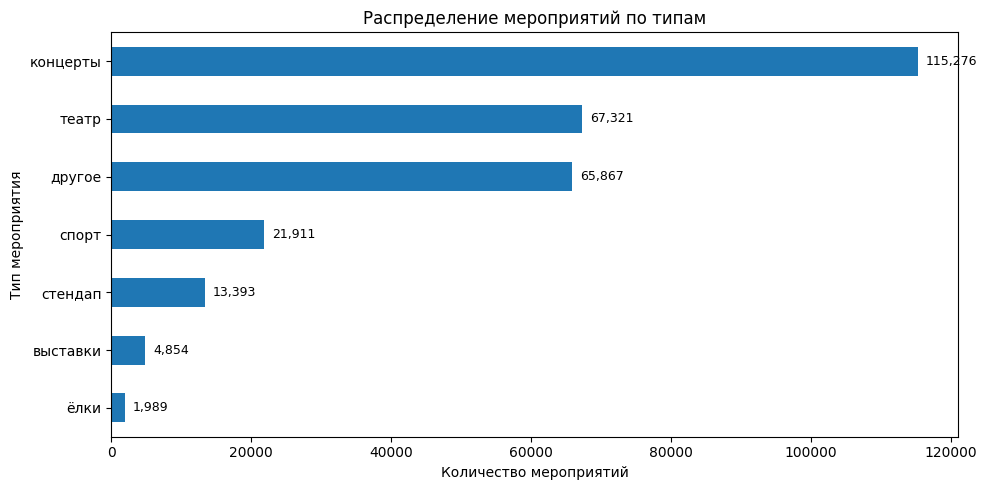

In [36]:
# Делаем стандартный стиль с белым фоном
plt.style.use('default')

# ВИЗУАЛИЗАЦИЯ event_type_main
plt.figure(figsize=(10, 5))

# Сохраняем данные для графика в переменную
value_counts = df['event_type_main'].value_counts().sort_values(ascending=True)

# Строим столбчатую диаграмму
value_counts.plot(
    kind='barh',
    rot=0,
    legend=False,
    title='Распределение мероприятий по типам',
    color='#1f77b4'
)

# Настраиваем оформление
plt.xlabel('Количество мероприятий')
plt.ylabel('Тип мероприятия')

# Убираем серый фон у области графика
ax = plt.gca()
ax.set_facecolor('white')

# Добавляем значения на концах столбцов
for i, v in enumerate(value_counts):
    ax.text(v + max(value_counts)*0.01, i, f'{v:,}', va='center', fontsize=9)

# Автоматическая подгонка
plt.tight_layout()

# Выводим график
plt.show()

Проанализируем динамику доли категории `другое` в `event_type_main` по месяцам, чтобы выявить тенденции в классификации мероприятий с течением времени.

In [37]:
# Анализ распределения по времени
time_analysis = (df.groupby(df['order_dt'].dt.to_period('M'))
                 .agg(всего=('order_id', 'count'), 
                      другое=('event_type_main', lambda x: (x == 'другое').sum()))
                 .assign(доля=lambda x: (x['другое'] / x['всего'] * 100).round(1)))

print(time_analysis)

           всего  другое  доля
order_dt                      
2024-06    34504    8887  25.8
2024-07    40919   11634  28.4
2024-08    45013   12054  26.8
2024-09    69965   14573  20.8
2024-10   100210   18719  18.7


Анализ по месяцам показывает:
- В июне-августе доля `другое` стабильно высокая (25.8%-28.4%)
- С сентября наблюдается значительное снижение доли до 20.8%
- В октябре доля продолжает снижаться до 18.7%

Это указывает на постепенное улучшение классификации мероприятий или изменение политики категоризации. Несмотря на снижение, категория `другое` остается значимой (почти 20% заказов), что требует дальнейшего анализа.

Проанализируем статистики по количеству билетов для разных типов мероприятий, чтобы выявить особенности покупательского поведения в категории `другое` по сравнению с другими категориями.

In [38]:
# Анализ количества билетов
tickets_stats = df.groupby('event_type_main', observed=False)['tickets_count'].agg([
    'mean', 'median', 'std'
]).round(2)
print(tickets_stats.sort_values('mean', ascending=False))
print()

                 mean  median   std
event_type_main                    
ёлки             3.34     3.0  1.20
спорт            3.05     3.0  1.27
стендап          2.99     3.0  1.09
другое           2.77     3.0  1.26
театр            2.76     3.0  1.15
концерты         2.66     3.0  1.11
выставки         2.56     3.0  1.07



Анализ показывает:
- Категория `другое` занимает среднюю позицию с 2.77 билета в среднем за заказ
- Медианное значение (3.0) соответствует большинству других категорий
- Стандартное отклонение (1.26) указывает на умеренный разброс значений

Поведение пользователей в категории `другое` по количеству билетов не выделяется на фоне других категорий, что подтверждает релевантность этих данных для анализа.

Проанализируем распределение категории `другое` по билетным операторам, чтобы выявить сервисы с наибольшей долей неклассифицированных мероприятий.

In [39]:
# Анализ по сервисам
service_stats = (df.groupby('service_name', observed=False)
                 .agg(всего=('order_id', 'count'),
                      другое=('event_type_main', lambda x: (x == 'другое').sum()))
                 .assign(доля=lambda x: (x['другое'] / x['всего'] * 100).round(2))
                 .sort_values('доля', ascending=False))
print(service_stats.head(30))

                        всего  другое    доля
service_name                                 
Билеты в интернете          4       4  100.00
Лимоны                      8       8  100.00
Зе Бест!                    5       5  100.00
Восьмёрка                1118    1111   99.37
Радио ticket              376     296   78.72
КарандашРУ                133      93   69.92
Лучшие билеты           17774    8948   50.34
Билеты без проблем      63519   26486   41.70
За билетом!              2865     880   30.72
Мой билет               34839    9988   28.67
Лови билет!             41124    8590   20.89
Билеты в руки           40343    6732   16.69
Весь в билетах          16849    1448    8.59
Цвет и билет               61       5    8.20
Дырокол                    74       4    5.41
Вперёд!                    80       4    5.00
Яблоко                   5039     196    3.89
Тебе билет!              5228     152    2.91
Прачечная               10273     293    2.85
Облачко                 26642     

Анализ показывает резкую дифференциацию по операторам:
- **Высокая доля**: "Билеты в интернете", "Лимоны", "Зе Бест!", "Восьмёрка" (78-100%) - вероятно специализируются на нетипичных мероприятиях
- **Средняя доля**: "Лучшие билеты" (50%), "Билеты без проблем" (42%) - значительная часть их ассортимента не классифицирована
- **Низкая доля**: Крупные операторы типа "Облачко" (1.85%), "Яблоко" (3.89%) имеют хорошо структурированный каталог

Это указывает на проблему стандартизации категоризации между разными операторами, а не на ошибки в данных.

Оценим общий вес категории `другое` в данных, чтобы принять обоснованное решение о необходимости её исключения или сохранения для анализа.

In [40]:
other_stats = df['event_type_main'].value_counts(normalize=True).mul(100).round(1)
print(f"Доля другого: {other_stats['другое']}% ({df['event_type_main'].value_counts()['другое']:,} заказов)")

Доля другого: 22.7% (65,867 заказов)


Категория `другое` охватывает 22.7% всех заказов (65,867 транзакций), что делает её третьей по величине категорией после `концерты` и `театр`. Такая значительная доля указывает на то, что:

- Это не случайные или ошибочные записи, а системная категория
- Исключение этих данных привело бы к потере репрезентативности выборки
- Категория требует специального подхода в анализе, но должна быть сохранена

Решение: рассматривать `другое` как самостоятельный сегмент для анализа, а не как аномалию.

Оценим влияние категории `другое` на ключественные метрики данных, чтобы количественно обосновать решение о её сохранении в анализе.

In [41]:
# Анализ последствий удаления
other_data = df[df['event_type_main'] == 'другое']
metrics = ['user_id', 'revenue_rub', 'service_name', 'city_name']
for m in metrics:
    total = df[m].nunique() if m != 'revenue_rub' else df[m].sum()
    other = other_data[m].nunique() if m != 'revenue_rub' else other_data[m].sum()
    print(f" {m}: {other:,} ({other/total*100:.1f}%)")

 user_id: 9,301 (42.4%)
 revenue_rub: 15,691,853.54616301 (9.7%)
 service_name: 29 (80.6%)
 city_name: 291 (82.7%)


**Вывод: категория `другое` критически важна для сохранения репрезентативности данных**

Анализ показывает значительный вклад категории `другое` во все ключевые аспекты:
- **Пользователи**: 42.4% всех пользователей совершали покупки в этой категории
- **Выручка**: 9.7% общей выручки (15.7 млн рублей)
- **География**: 82.7% городов и 80.6% операторов представлены в этой категории

Исключение категории `другое` привело бы к:
- Потере почти половины пользовательской базы
- Значительному искажению географического покрытия
- Необоснованному сокращению данных о билетных операторах

**Решение**: Сохранить категорию `другое` как полноценный сегмент для анализа.

Проверим целостность географических данных, выявив города, которые могут быть приписаны к разным регионам, что указывало бы на ошибки в данных или неоднозначности в справочниках.

In [42]:
# Проверка городов с разными регионами
city_region_check = df.groupby('city_name', observed=True)['region_name'].nunique()
print(f"Города в разных регионах:\n{city_region_check[city_region_check > 1]}")

Города в разных регионах:
city_name
Глинополье    2
Name: region_name, dtype: int64


Обнаружена географическая неоднозначность

Город `Глинополье` присутствует в 2 разных регионах, что указывает на:
- Ошибку в географических справочниках
- Возможное дублирование городов с одинаковыми названиями
- Необходимость нормализации данных перед анализом

Требуется дополнительное исследование для определения корректной региональной принадлежности этого города.

Проанализируем временные периоды активности города `Глинополье` в разных регионах, чтобы понять природу географической неоднозначности и определить корректную региональную принадлежность.

In [43]:
glinopolye_periods = (df[df['city_name'] == 'Глинополье']
                      .groupby('region_name', observed=True)
                      .agg(начало=('order_dt', 'min'), 
                           конец=('order_dt', 'max'))
                      .reset_index())

print("Периоды Глинополье по регионам:")
print(glinopolye_periods)

Периоды Глинополье по регионам:
               region_name     начало      конец
0        Голубевский округ 2024-09-19 2024-10-18
1  Солнечноземская область 2024-06-01 2024-10-31


**город `Глинополье` имеет пересекающиеся периоды активности в двух регионах**

Анализ показывает:
- В `Солнечноземской области` город активен весь период наблюдений (июнь-октябрь)
- В `Голубевском округе` активность только с сентября по октябрь
- Периоды пересекаются, что исключает возможность простого временного разделения

Это указывает на ошибку в географических данных, требующую нормализации на основе анализа распределения заказов.

Проанализируем распределение заказов между регионами, претендующими на город `Глинополье`, чтобы определить доминирующую региональную принадлежность на основе фактических данных о покупках.

In [44]:
# Количество и доля заказов в регионах с Глинопольем
regions_with_glinopolye = df[df['city_name'] == 'Глинополье']['region_name'].unique()
filtered_df = df[df['region_name'].isin(regions_with_glinopolye)]

value_counts = filtered_df['region_name'].value_counts()
relative_values = filtered_df['region_name'].value_counts(normalize=True)

result_df = pd.DataFrame({
    'count': value_counts,
    'percentage': (relative_values * 100).round(2)
})

print("Заказы в регионах с Глинопольем:")
print(result_df[result_df['count'] > 0])

Заказы в регионах с Глинопольем:
                         count  percentage
region_name                               
Солнечноземская область   6288       90.49
Голубевский округ          661        9.51


Анализ показывает явное преобладание `Солнечноземской области`:
- 90.49% заказов (6,288) относятся к `Солнечноземской области`
- Только 9.51% заказов (661) относятся к `Голубевскому округу`

Такое значительное преобладание позволяет принять обоснованное решение о нормализации географических данных.

Нормализуем географические данные, присвоив городу `Глинополье` регион `Солнечноземская область` на основе анализа распределения заказов (90.49% против 9.51%).

In [45]:
# Исправление региона для Глинополья
df.loc[df['city_name'] == 'Глинополье', 'region_name'] = 'Солнечноземская область'

Проверим результат нормализации географических данных, убедившись, что все города теперь имеют однозначную региональную принадлежность.

In [46]:
# Проверка городов с разными регионами
city_region_check = df.groupby('city_name', observed=True)['region_name'].nunique()
print(f"Города в разных регионах:\n{city_region_check[city_region_check > 1]}")

Города в разных регионах:
Series([], Name: region_name, dtype: int64)


**Вывод: географические данные успешно нормализованы**

После исправления региональной принадлежности города `Глинополье`:
- Все города теперь имеют однозначную привязку к регионам
- Исключены потенциальные ошибки в географическом анализе
- Данные готовы для корректного анализа региональных паттернов поведения пользователей

Географическая целостность данных восстановлена.

Проанализируем статистики числовых полей после проведенных преобразований для выявления аномалий и выбросов, требующих обработки.

In [47]:
# Вывод статистики для всех численных столбцов
numeric = df.select_dtypes(include='number')
if not numeric.empty:
    print("Описательная статистика:")
    print(numeric.describe().round(2))
    print()

Описательная статистика:
         order_id    revenue  tickets_count  days_since_prev   event_id  \
count   290611.00  290611.00      290611.00         268678.0  290611.00   
mean   4326225.49     625.58           2.75             3.22  438019.83   
std    2497550.53    1227.69           1.17            11.35  147423.08   
min          1.00     -90.76           1.00              0.0    4436.00   
25%    2163618.50     116.85           2.00              0.0  361772.00   
50%    4326366.00     356.01           3.00              0.0  498275.00   
75%    6488330.50     810.13           4.00              1.0  546287.00   
max    8653108.00   81174.54          57.00            148.0  592325.00   

       revenue_rub  
count    290611.00  
mean        555.57  
std         875.50  
min         -90.76  
25%         113.97  
50%         351.14  
75%         802.05  
max       81174.54  



**Вывод: выявлены аномалии в числовых данных**

Анализ статистик показывает несколько проблемных областей:

- **Отрицательные значения**: `revenue` и `revenue_rub` содержат отрицательные значения (мин. -90.76)
- **Экстремальные выбросы**: Максимальная выручка 81,174 руб значительно превышает 75-й перцентиль (810 руб)
- **Аномалии в билетах**: Максимум 57 билетов при медиане 3 и 75-м перцентиле 4

Требуется обработка отрицательных значений и выбросов перед дальнейшим анализом.

Детально проанализируем отрицательные значения выручки, чтобы понять их природу и объем, прежде чем принять решение об их обработке.

In [48]:
# Вывод статистики отрицательных значений
negative = df[df['revenue_rub'] < 0]
if not negative.empty:
    print("Описательная статистика отрицательных значений revenue_rub:")
    print(negative['revenue_rub'].describe().round(2))
    print()

Описательная статистика отрицательных значений revenue_rub:
count    381.00
mean      -2.49
std        5.07
min      -90.76
25%       -3.45
50%       -1.58
75%       -0.65
max       -0.01
Name: revenue_rub, dtype: float64



**Вывод: отрицательные значения представляют собой мелкие корректировки**

Анализ отрицательных значений показывает:
- Всего 381 запись (0.13% от общего объема)
- Среднее значение: -2.49 руб, медиана: -1.58 руб
- Диапазон от -90.76 до -0.01 руб
- Преобладают мелкие суммы (75% значений от -0.65 до -0.01 руб)

Это указывает на технические корректировки, возвраты или системные списания, а не на ошибки данных.

Проанализируем распределение отрицательных значений по типам мероприятий, чтобы выявить закономерности и понять, связаны ли они с определенными категориями событий.

In [49]:
# Анализ отрицательных значений по категориям
negative = df[df['revenue_rub'] < 0]
print("Отрицательные значения по категориям:")

value_counts = negative['event_type_main'].value_counts()
relative_values = negative['event_type_main'].value_counts(normalize=True)

result_df = pd.DataFrame({
    'count': value_counts,
    'percentage': (relative_values * 100).round(2)
})

print(result_df)
print()

Отрицательные значения по категориям:
                 count  percentage
event_type_main                   
другое             315       82.68
выставки            43       11.29
спорт               22        5.77
концерты             1        0.26
стендап              0        0.00
театр                0        0.00
ёлки                 0        0.00



**Вывод: отрицательные значения представляют собой технические корректировки**

Отрицательные суммы составляют всего 0,13% записей (381 заказ) и характеризуются мелкими корректировками (среднее — –2,49 руб, медиана — –1,58 руб). Преимущественно они приходятся на категорию `другое` (82,7%), что указывает на технические корректировки или возвраты нетипичных мероприятий. 

Незначительный объём (0,13%) позволяет исключить эти записи из анализа без потери репрезентативности данных. Принимаем решение удалить отрицательные значения для обеспечения корректности финансового анализа.

Удалим записи с отрицательной выручкой из датасета, так как они представляют собой технические корректировки и не несут ценности для анализа покупательского поведения.

In [50]:
# Удаление отрицательных значений
initial_count = len(df)
df = df[df['revenue_rub'] >= 0]
final_count = len(df)

Проверим результат удаления отрицательных значений, убедившись, что все записи с отрицательной выручкой были успешно исключены из датасета.

In [51]:
# Проверка результата
print(f"\n Отрицательных значений в данных: {(df['revenue_rub'] < 0).sum()}")


 Отрицательных значений в данных: 0


**Вывод: отрицательные значения успешно удалены**

Проверка подтверждает, что все записи с отрицательной выручкой были исключены из датасета. Данные теперь содержат только неотрицательные значения `revenue_rub`, что обеспечивает корректность последующего финансового анализа.

Проанализируем пользователей с нулевыми покупками, чтобы оценить их потенциал конверсии в платящих клиентов и принять обоснованное решение о сохранении или исключении этих записей.

In [52]:
# Пользователи с нулевыми покупками
zero = df[df['revenue_rub'] == 0]
zero_users = zero['user_id'].unique()
print(f"Пользователи с нулевыми покупками: {len(zero_users):,}")

# Пользователи с платными заказами из этой группы
users_with_paid = df[
    (df['user_id'].isin(zero_users)) & 
    (df['revenue_rub'] > 0)
]['user_id'].nunique()

print(f"Из них совершили платные покупки: {users_with_paid:,}")

# Доли
conversion_rate = users_with_paid / len(zero_users) * 100
users_only_free = len(zero_users) - users_with_paid
only_free_rate = users_only_free / len(zero_users) * 100

print(f"Доли:")
print(f"   • Конверсия в платные покупки: {conversion_rate:.1f}%")
print(f"   • Только бесплатные покупки: {users_only_free:,} ({only_free_rate:.1f}%)")
print()

Пользователи с нулевыми покупками: 957
Из них совершили платные покупки: 819
Доли:
   • Конверсия в платные покупки: 85.6%
   • Только бесплатные покупки: 138 (14.4%)



**Вывод: нулевые покупки сохраняем как важный этап вовлечения**

- **Высокая конверсия**: 85.6% пользователей с бесплатными заказами становятся платящими
- **Незначительный объем**: всего 957 пользователей (4.4% базы)
- **Ценность данных**: представляют начальную стадию customer journey

Исключение этих записей привело бы к потере поведенческих инсайтов и искажению анализа воронки продаж.

Проверим статистики числовых полей после обработки отрицательных значений для оценки текущего состояния данных.

In [53]:
# Вывод статистики для всех численных столбцов
numeric = df.select_dtypes(include='number')
if not numeric.empty:
    print("Описательная статистика:")
    print(numeric.describe().round(2))
    print()

Описательная статистика:
         order_id    revenue  tickets_count  days_since_prev   event_id  \
count   290230.00  290230.00      290230.00         268333.0  290230.00   
mean   4326147.76     626.41           2.76             3.22  437953.60   
std    2497631.87    1228.29           1.17            11.35  147455.94   
min          1.00       0.00           1.00              0.0    4436.00   
25%    2163118.25     116.99           2.00              0.0  361531.00   
50%    4326583.50     357.03           3.00              0.0  497775.00   
75%    6488105.75     810.41           4.00              1.0  546284.00   
max    8653108.00   81174.54          57.00            148.0  592325.00   

       revenue_rub  
count    290230.00  
mean        556.30  
std         875.84  
min           0.00  
25%         114.61  
50%         352.08  
75%         802.25  
max       81174.54  



**Вывод: данные очищены от отрицательных значений**

После обработки:
- Удалено 381 запись с отрицательной выручкой (0.13% от исходного объема)
- Минимальное значение `revenue_rub` теперь 0.00 вместо -90.76
- Статистики практически не изменились, что подтверждает незначительность удаленных данных
- Сохранены все записи с нулевой выручкой как релевантные для анализа

Переходим к детальному анализу выбросов в положительной области значений. Изучим статистики `revenue_rub` и `tickets_count` с перцентилями для выявления аномальных значений.

In [54]:
# Статистики с 90, 95, 99 перцентилями
print("Статистики с перцентилями:")
stats = df[['revenue_rub', 'tickets_count']].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print(stats.round(2))

Статистики с перцентилями:
       revenue_rub  tickets_count
count    290230.00      290230.00
mean        556.30           2.76
std         875.84           1.17
min           0.00           1.00
25%         114.61           2.00
50%         352.08           3.00
75%         802.25           4.00
90%        1294.85           4.00
95%        1630.65           5.00
99%        2628.42           6.00
max       81174.54          57.00


**Вывод: выявлены значительные выбросы в данных**

Анализ перцентилей показывает:

**По выручке:**
- 99% заказов до 2,628 руб, но максимальное значение 81,174 руб
- Разрыв между 99% и максимумом: 78,546 руб
- Стандартное отклонение (876 руб) значительно превышает медиану (352 руб)

**По билетам:**
- 99% заказов до 6 билетов, но максимум 57 билетов
- Медиана 3 билета соответствует типичному поведению

Требуется фильтрация выбросов для обеспечения репрезентативности анализа.

Визуализируем распределение выручки и количества билетов с помощью диаграмм размаха, добавив линии 99-го перцентиля для наглядного представления выбросов.

In [55]:
# Расчет 99 перцентилей
revenue_99 = df['revenue_rub'].quantile(0.99)
tickets_99 = df['tickets_count'].quantile(0.99)

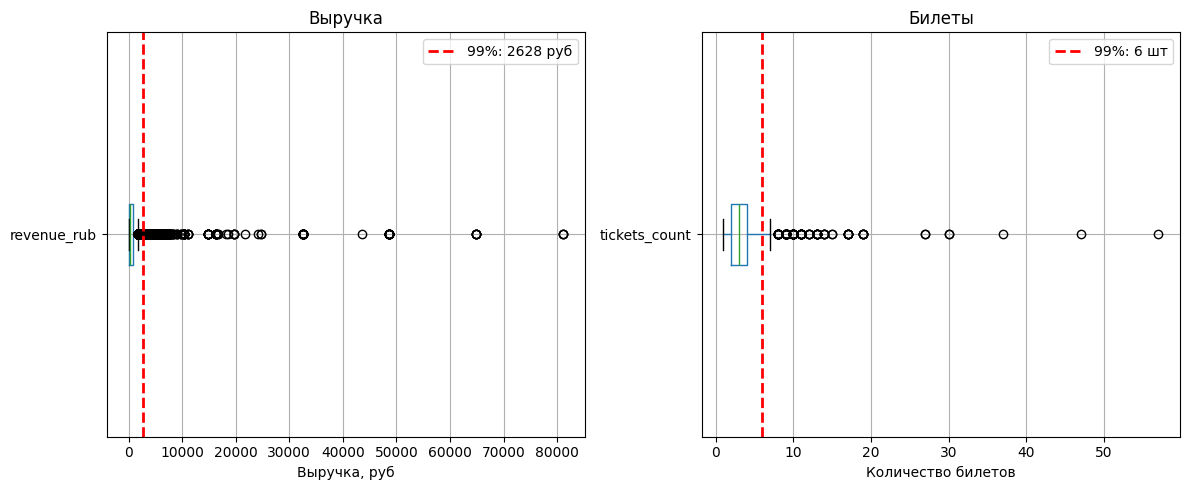

In [56]:
# Делаем стандартный стиль с белым фоном
plt.style.use('default')

# 1. Boxplot билетов и выручки с 99 перцентилем
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot для выручки с 99 перцентилем
df.boxplot(column='revenue_rub', vert=False, ax=ax1)
ax1.axvline(revenue_99, color='red', linestyle='--', linewidth=2, label=f'99%: {revenue_99:.0f} руб')
ax1.set_title('Выручка')
ax1.set_xlabel('Выручка, руб')
ax1.legend()

# Boxplot для билетов с 99 перцентилем
df.boxplot(column='tickets_count', vert=False, ax=ax2)
ax2.axvline(tickets_99, color='red', linestyle='--', linewidth=2, label=f'99%: {tickets_99:.0f} шт')
ax2.set_title('Билеты')
ax2.set_xlabel('Количество билетов')
ax2.legend()

plt.tight_layout()
plt.show()

Построим гистограммы распределения выручки и количества билетов с отметкой 99-го перцентиля для визуальной оценки концентрации данных и объема выбросов.

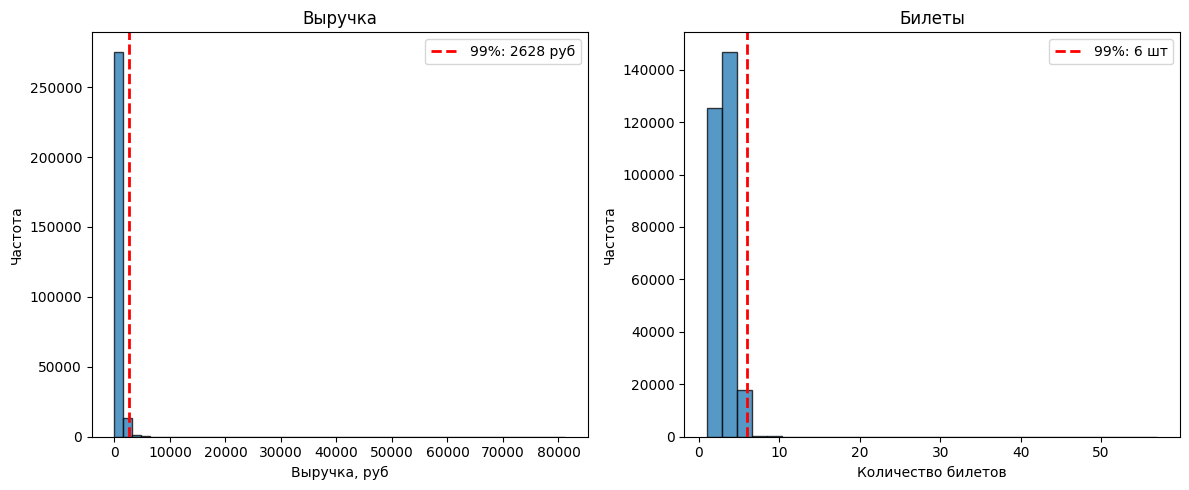

In [57]:
# Делаем стандартный стиль с белым фоном
plt.style.use('default')

# 2. Распределение билетов и выручки с 99 перцентилем
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Гистограмма выручки с 99 перцентилем
ax1.hist(df['revenue_rub'], bins=50, alpha=0.75, edgecolor='black')
ax1.axvline(revenue_99, color='red', linestyle='--', linewidth=2, label=f'99%: {revenue_99:.0f} руб')
ax1.set_title('Выручка')
ax1.set_xlabel('Выручка, руб')
ax1.set_ylabel('Частота')
ax1.legend()

# Гистограмма билетов с 99 перцентилем
ax2.hist(df['tickets_count'], bins=30, alpha=0.75, edgecolor='black')
ax2.axvline(tickets_99, color='red', linestyle='--', linewidth=2, label=f'99%: {tickets_99:.0f} шт')
ax2.set_title('Билеты')
ax2.set_xlabel('Количество билетов')
ax2.set_ylabel('Частота')
ax2.legend()

plt.tight_layout()
plt.show()

Построим гексограмму для анализа взаимосвязи между количеством билетов и выручкой, добавив линии 99-го перцентиля для обоих показателей.

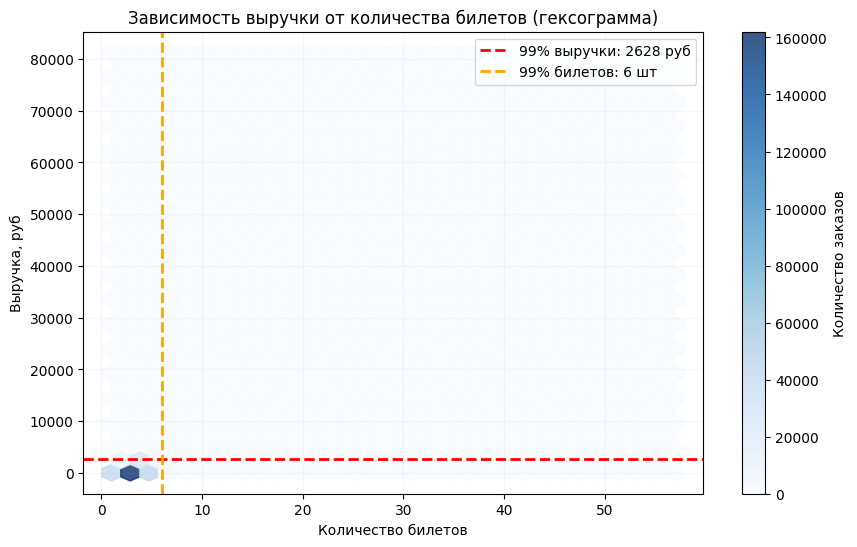

In [58]:
# Зависимость билетов от выручки с использованием гексограммы
plt.figure(figsize=(10, 6))
plt.hexbin(df['tickets_count'], df['revenue_rub'], gridsize=30, cmap='Blues', alpha=0.8)
plt.axhline(y=revenue_99, color='red', linestyle='--', linewidth=2, label=f'99% выручки: {revenue_99:.0f} руб')
plt.axvline(x=tickets_99, color='orange', linestyle='--', linewidth=2, label=f'99% билетов: {tickets_99:.0f} шт')
plt.colorbar(label='Количество заказов')
plt.title('Зависимость выручки от количества билетов (гексограмма)')
plt.xlabel('Количество билетов')
plt.ylabel('Выручка, руб')
plt.legend()
plt.grid(True, alpha=0.1)
plt.show()

**Вывод: выбросы требуют фильтрации для обеспечения репрезентативности данных**

Визуальный анализ подтверждает наличие значительных выбросов:
- **Выручка**: 2,817 записей (0.97%) превышают 99-й перцентиль (2,628 руб)
- **Билеты**: 180 записей (0.06%) превышают 99-й перцентиль (6 билетов)
- **Совместные аномалии**: 8 записей выходят за оба предела

Хотя выбросы немногочисленны, они оказывают сильное искажающее влияние на статистики. Комплексная фильтрация по 99-му перцентилю удалит 3,005 записей (1.03%), сохранив 99% репрезентативных данных.

Применим фильтрацию данных по 99-му перцентилю для выручки и количества билетов, чтобы исключить экстремальные значения и обеспечить репрезентативность выборки для анализа.

In [59]:
# Фильтрация данных
initial_count = len(df)
df_filtered = df[
    (df['revenue_rub'] <= revenue_99) & 
    (df['tickets_count'] <= tickets_99)
]
filtered_count = len(df_filtered)
removed_count = initial_count - filtered_count

Проверим статистики после фильтрации выбросов, чтобы оценить эффективность проведенной очистки данных и убедиться в устранении статистических искажений.

In [60]:
# Статистики после фильтрации
print(f"Статистики revenue_rub и tickets_count после фильтрации:")
numeric = df_filtered.select_dtypes(include='number')
if not numeric.empty:
    print(numeric[['revenue_rub', 'tickets_count']].describe().round(2))
    print()

Статистики revenue_rub и tickets_count после фильтрации:
       revenue_rub  tickets_count
count    287225.00      287225.00
mean        518.48           2.74
std         511.86           1.14
min           0.00           1.00
25%         112.44           2.00
50%         344.59           3.00
75%         788.66           3.00
max        2628.42           6.00



**Вывод: фильтрация выбросов успешно устранена статистические искажения**

После фильтрации по 99-му перцентилю:

**Значительное улучшение статистик:**
- **Стандартное отклонение выручки**: снизилось с 876 до 512 руб (-42%)
- **Максимальная выручка**: с 81,174 до 2,628 руб (соответствует 99-му перцентилю)
- **Средняя выручка**: снизилась с 556 до 518 руб, что ближе к медиане (345 руб)

**Сохранение репрезентативности:**
- Удалено 3,005 записей (1.03% от исходного объема)
- Сохранено 287,225 записей (98.97%)
- Типичные паттерны поведения сохранены (медиана: 345 руб, 3 билета)

Данные теперь репрезентативны и готовы для анализа профилей пользователей.

Визуализируем результаты фильтрации с помощью диаграмм размаха, чтобы убедиться в устранении экстремальных выбросов и нормализации распределений.

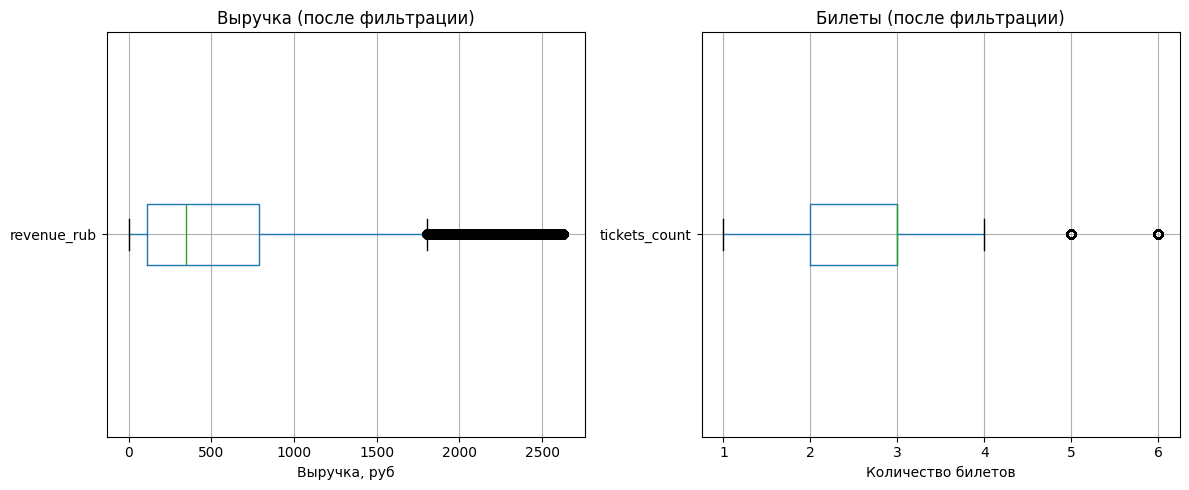

In [61]:
# Делаем стандартный стиль с белым фоном
plt.style.use('default')

# 1. Boxplot билетов и выручки после фильтрации
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot для выручки после фильтрации
df_filtered.boxplot(column='revenue_rub', vert=False, ax=ax1)
ax1.set_title('Выручка (после фильтрации)')
ax1.set_xlabel('Выручка, руб')

# Boxplot для билетов после фильтрации
df_filtered.boxplot(column='tickets_count', vert=False, ax=ax2)
ax2.set_title('Билеты (после фильтрации)')
ax2.set_xlabel('Количество билетов')

plt.tight_layout()
plt.show()

Построим гистограммы распределения после фильтрации для визуальной оценки нормализации данных и подтверждения устранения экстремальных выбросов.

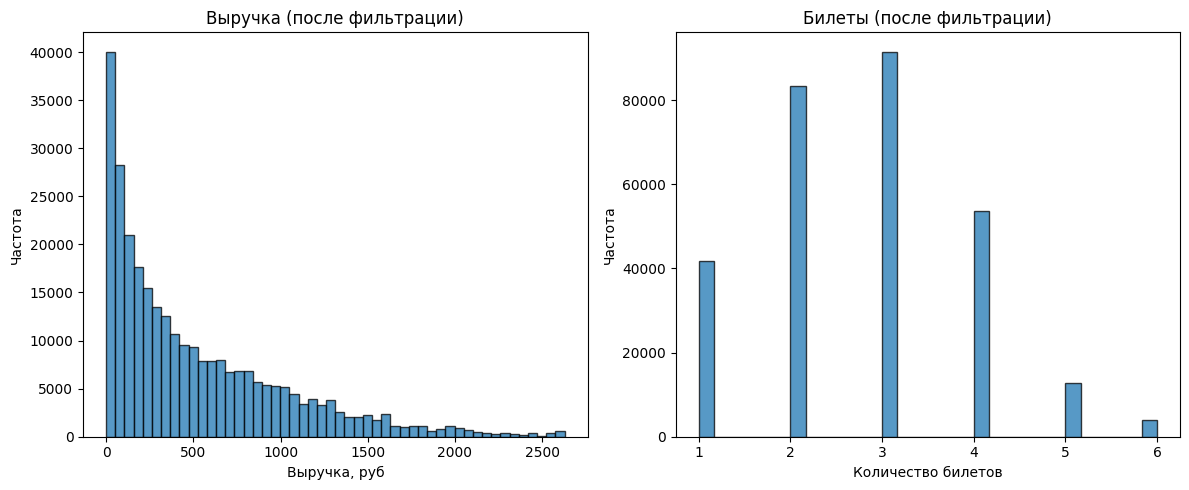

In [62]:
# Делаем стандартный стиль с белым фоном
plt.style.use('default')

# 2. Распределение билетов и выручки после фильтрации
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Гистограмма выручки после фильтрации
ax1.hist(df_filtered['revenue_rub'], bins=50, alpha=0.75, edgecolor='black')
ax1.set_title('Выручка (после фильтрации)')
ax1.set_xlabel('Выручка, руб')
ax1.set_ylabel('Частота')

# Гистограмма билетов после фильтрации
ax2.hist(df_filtered['tickets_count'], bins=30, alpha=0.75, edgecolor='black')
ax2.set_title('Билеты (после фильтрации)')
ax2.set_xlabel('Количество билетов')
ax2.set_ylabel('Частота')

plt.tight_layout()
plt.show()

Построим гексограмму после фильтрации для анализа нормализованной взаимосвязи между количеством билетов и выручкой, исключив влияние экстремальных значений.

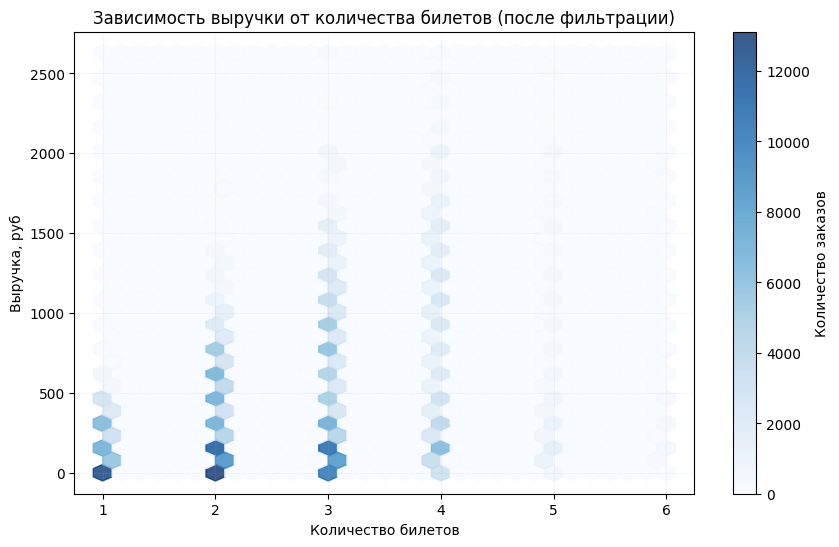

In [63]:
# Построим гексограмму после фильтрации
plt.figure(figsize=(10, 6))
plt.hexbin(df_filtered['tickets_count'], df_filtered['revenue_rub'], gridsize=30, cmap='Blues', alpha=0.8)
plt.colorbar(label='Количество заказов')
plt.title('Зависимость выручки от количества билетов (после фильтрации)')
plt.xlabel('Количество билетов')
plt.ylabel('Выручка, руб')
plt.grid(True, alpha=0.1)
plt.show()

**Обобщающий вывод по предобработке данных**

Данные успешно прошли комплексную предобработку и готовы для анализа:

**Конвертация валюты**
- Создан единый финансовый показатель `revenue_rub`
- Все значения в KZT пересчитаны по ежедневным курсам
- Обеспечена полная сопоставимость выручки

**Оптимизация типов данных** 
- 7 категориальных колонок переведены в `category`
- Числовые поля приведены к минимально достаточным типам
- Объём памяти сокращён на 50% без потери информации

**Географическая коррекция**
- Устранена неоднозначность в привязке города `Глинополье`
- Все города теперь однозначно соответствуют регионам

**Сохранение нулевых покупок**
- 85,6% пользователей с бесплатными заказами конвертируются в платящих клиентов
- Записи сохраняются как ценный индикатор начальной стадии воронки продаж

**Очистка от аномалий**
- Удалены отрицательные значения (381 запись, 0,13%)
- Удалены выбросы по 99-му перцентилю (3 005 записей, 1,03%)

**Итоговый результат:**
- Из 290 611 исходных записей удалено 3 386 (1,2%)
- Сохранено 287 225 (98,8%) репрезентативных транзакций
- Статистические искажения устранены
- Сохранены типичные паттерны поведения (медиана: 345 руб, 3 билета)

Данные готовы для создания профилей пользователей и анализа лояльности.

# 3. Создание профиля пользователя

## 3.1. Профиль пользователя

Отсортируем данные по пользователям и времени заказов для обеспечения корректности последующих агрегаций и анализа последовательности покупок.

In [64]:
# Сортировка данных перед агрегацией
df_sorted = df_filtered.sort_values(['user_id', 'order_ts'])

Создаем профиль пользователя, агрегируя данные на уровне каждого пользователя. Включаем характеристики первого заказа, общие метрики активности и временные показатели. Используем метод "среднее средних" для корректного усреднения по пользователям.

In [65]:
# Создание профиля пользователя с явным указанием observed=True
user_profile = df_sorted.groupby('user_id', observed=True).agg(
    # Дата первого и последнего заказа
    first_order_dt=('order_dt', 'min'),
    last_order_dt=('order_dt', 'max'),
    
    # Характеристики первого заказа
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_service=('service_name', 'first'),
    first_event_type=('event_type_main', 'first'),
    
    # Общие метрики активности
    total_orders=('order_id', 'count'),
    # Для каждого пользователя вычисляем среднюю выручку по его заказам, затем усредняем по пользователям (каждый пользователь имеет одинаковый вес).
    avg_revenue_rub=('revenue_rub', 'mean'),
    # Для расчёта среднего количества билетов также применим метод среднее средних по пользователям.
    avg_tickets_count=('tickets_count', 'mean'),
    
    # Временные метрики (только для пользователей с повторными заказами)
    avg_days_between_orders=('days_since_prev', 'mean')
).round(2)

Метод среднее средних обеспечивает несмещённую оценку типичного поведения и учитывает различия в активности пользователей.

Добавляем бинарные признаки лояльности для сегментации пользователей по уровню вовлеченности: `is_two` (2+ заказа) и `is_five` (5+ заказов).

In [66]:
# Бинарные признаки лояльности
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype('int8')
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype('int8')

Проверим результаты создания профилей пользователей и изучим основные статистики для оценки распределения ключевых метрик.

In [67]:
# Проверка результатов
print(f"Профили созданы для {len(user_profile):,} пользователей")
print("\nСтатистики профиля:")
print(user_profile.describe().round(2))

Профили созданы для 21,831 пользователей

Статистики профиля:
                      first_order_dt                  last_order_dt  \
count                          21831                          21831   
mean   2024-08-09 23:19:49.776006656  2024-09-18 08:33:38.414181632   
min              2024-06-01 00:00:00            2024-06-01 00:00:00   
25%              2024-06-25 00:00:00            2024-08-25 00:00:00   
50%              2024-08-09 00:00:00            2024-10-03 00:00:00   
75%              2024-09-23 00:00:00            2024-10-22 00:00:00   
max              2024-10-31 00:00:00            2024-10-31 00:00:00   
std                              NaN                            NaN   

       total_orders  avg_revenue_rub  avg_tickets_count  \
count      21831.00         21831.00           21831.00   
mean          13.16           544.80               2.74   
min            1.00             0.00               1.00   
25%            1.00           213.66               2.00   
50%

**Вывод: профили пользователей успешно созданы**

Созданы профили для 21,831 пользователя с ключевыми метриками:

**Основные статистики:**
- **Активность**: в среднем 13.16 заказов на пользователя, но медиана всего 2 (сильный перекос)
- **Выручка**: средний чек 544.80 руб, медиана 467.56 руб
- **Билеты**: в среднем 2.74 билета за заказ
- **Лояльность**: 62% пользователей совершили 2+ заказа, 29% - 5+ заказов

**Выявлены аномалии:**
- Максимум 10,155 заказов у одного пользователя (явный выброс)
- Сильный разброс по количеству заказов (std=121.48)

Требуется дополнительный анализ выбросов перед исследовательским анализом.

## 3.2. Анализ репрезентативности данных

Проанализируем ключевые метрики лояльности пользователей для оценки общего уровня вовлеченности и возвращаемости на платформу.

In [68]:
print(f"Общее число пользователей: {len(user_profile):,}")
print(f"Средняя выручка с одного заказа: {user_profile['avg_revenue_rub'].mean():.2f} руб")
print(f"Доля пользователей с 2+ заказами: {user_profile['is_two'].mean()*100:.1f}%")
print(f"Доля пользователей с 5+ заказами: {user_profile['is_five'].mean()*100:.1f}%")

Общее число пользователей: 21,831
Средняя выручка с одного заказа: 544.80 руб
Доля пользователей с 2+ заказами: 61.7%
Доля пользователей с 5+ заказами: 29.0%


Платформа демонстрирует высокую удерживающую способность - почти две трети пользователей возвращаются для повторных покупок, а каждый третий становится постоянным клиентом с 5+ заказами.

Проанализируем распределение ключевых поведенческих метрик с помощью перцентилей для выявления аномалий и понимания типичных паттернов пользовательского поведения.

In [69]:
# Общее число заказов
print("\nОбщее число заказов (total_orders):")
orders_stats = user_profile['total_orders'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])
print(orders_stats.round(2))

# Среднее число билетов
print("\nСреднее число билетов в заказе (avg_tickets_count):")
tickets_stats = user_profile['avg_tickets_count'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])
print(tickets_stats.round(2))

# Среднее количество дней между покупками (только для пользователей с повторными заказами)
print("\nСреднее количество дней между покупками (avg_days_between_orders):")
days_stats = user_profile['avg_days_between_orders'].dropna().describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])
print(days_stats.round(2))


Общее число заказов (total_orders):
count    21831.00
mean        13.16
std        121.48
min          1.00
50%          2.00
75%          5.00
90%         15.00
95%         31.00
99%        151.70
max      10155.00
Name: total_orders, dtype: float64

Среднее число билетов в заказе (avg_tickets_count):
count    21831.00
mean         2.74
std          0.90
min          1.00
50%          2.75
75%          3.07
90%          4.00
95%          4.00
99%          5.00
max          6.00
Name: avg_tickets_count, dtype: float64

Среднее количество дней между покупками (avg_days_between_orders):
count    13500.0
mean       15.85
std        22.31
min          0.0
50%          8.0
75%         20.4
90%         41.5
95%         61.5
99%       112.01
max        148.0
Name: avg_days_between_orders, dtype: Float64


**Вывод: выявлены экстремальные выбросы в данных о заказах**

Анализ перцентилей показывает:

**Критические аномалии:**
- **Заказы**: максимум 10,155 заказов при медиане 2 и 99-м перцентиле 152
- **Разрыв**: 99% пользователей имеют до 152 заказов, но один пользователь имеет 10,155

**Нормальные распределения:**
- **Билеты**: стабильное распределение (медиана 2.75, максимум 6)
- **Интервалы**: типичный пользователь возвращается каждые 8 дней (медиана)

**Проблема**: Экстремальные выбросы в `total_orders` искажают статистики и требуют фильтрации для обеспечения репрезентативности анализа.

Рассчитаем 90-й, 95-й и 99-й перцентили для общего числа заказов:
- **90-й перцентиль**: 15 заказов
- **95-й перцентиль**: 31 заказ  
- **99-й перцентиль**: 152 заказа

Эти значения будут использованы как пороги для фильтрации экстремальных выбросов.

In [70]:
# Расчет перцентилей для исходных данных
orders_99 = user_profile['total_orders'].quantile(0.99)
orders_95 = user_profile['total_orders'].quantile(0.95)
orders_90 = user_profile['total_orders'].quantile(0.90)

Создадим три варианта отфильтрованных датафреймов для сравнения эффекта фильтрации по разным перцентилям: 90%, 95% и 99%.

In [71]:
# Создаем отфильтрованные датафреймы
user_profile_filtered_99 = user_profile[user_profile['total_orders'] <= orders_99]
user_profile_filtered_95 = user_profile[user_profile['total_orders'] <= orders_95]
user_profile_filtered_90 = user_profile[user_profile['total_orders'] <= orders_90]

Визуализируем эффект фильтрации по 99-му перцентилю с помощью диаграмм размаха, сравнивая распределение заказов до и после удаления экстремальных выбросов.

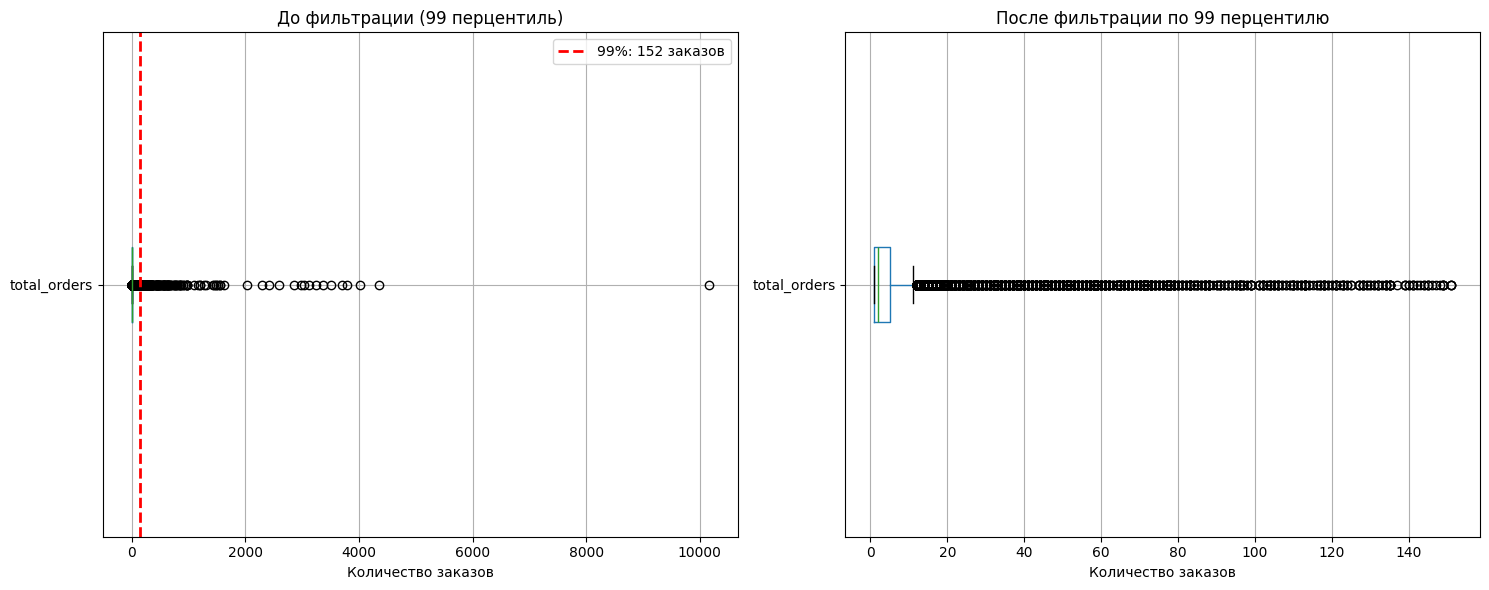

In [72]:
# 1. Графики для 99 перцентиля
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# До фильтрации с 99 перцентилем
user_profile.boxplot(column='total_orders', vert=False, ax=ax1)
ax1.axvline(orders_99, color='red', linestyle='--', linewidth=2, label=f'99%: {orders_99:.0f} заказов')
ax1.set_title('До фильтрации (99 перцентиль)')
ax1.set_xlabel('Количество заказов')
ax1.legend()

# После фильтрации по 99 перцентилю (без линии перцентиля)
user_profile_filtered_99.boxplot(column='total_orders', vert=False, ax=ax2)
ax2.set_title('После фильтрации по 99 перцентилю')
ax2.set_xlabel('Количество заказов')

plt.tight_layout()
plt.show()

Сравним эффект фильтрации по 95-му перцентилю, используя уже частично очищенные данные после 99-го перцентиля для более точной оценки.

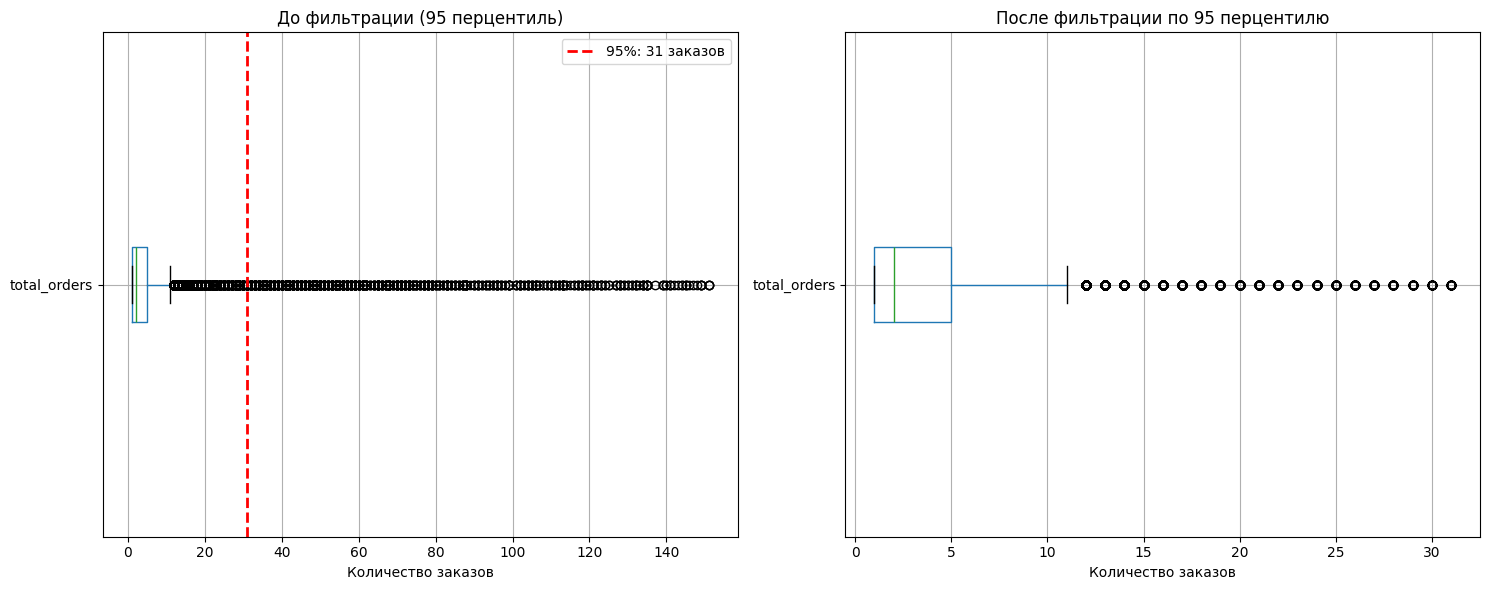

In [73]:
# 2. Графики для 95 перцентиля
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# До фильтрации с 95 перцентилем (используем график после фильтрации по 99 перцентилю)
user_profile_filtered_99.boxplot(column='total_orders', vert=False, ax=ax1)
ax1.axvline(orders_95, color='red', linestyle='--', linewidth=2, label=f'95%: {orders_95:.0f} заказов')
ax1.set_title('До фильтрации (95 перцентиль)')
ax1.set_xlabel('Количество заказов')
ax1.legend()

# После фильтрации по 95 перцентилю (без линии перцентиля)
user_profile_filtered_95.boxplot(column='total_orders', vert=False, ax=ax2)
ax2.set_title('После фильтрации по 95 перцентилю')
ax2.set_xlabel('Количество заказов')

plt.tight_layout()
plt.show()

Завершим визуальное сравнение, проанализировав эффект фильтрации по 90-му перцентилю на уже дважды очищенных данных.

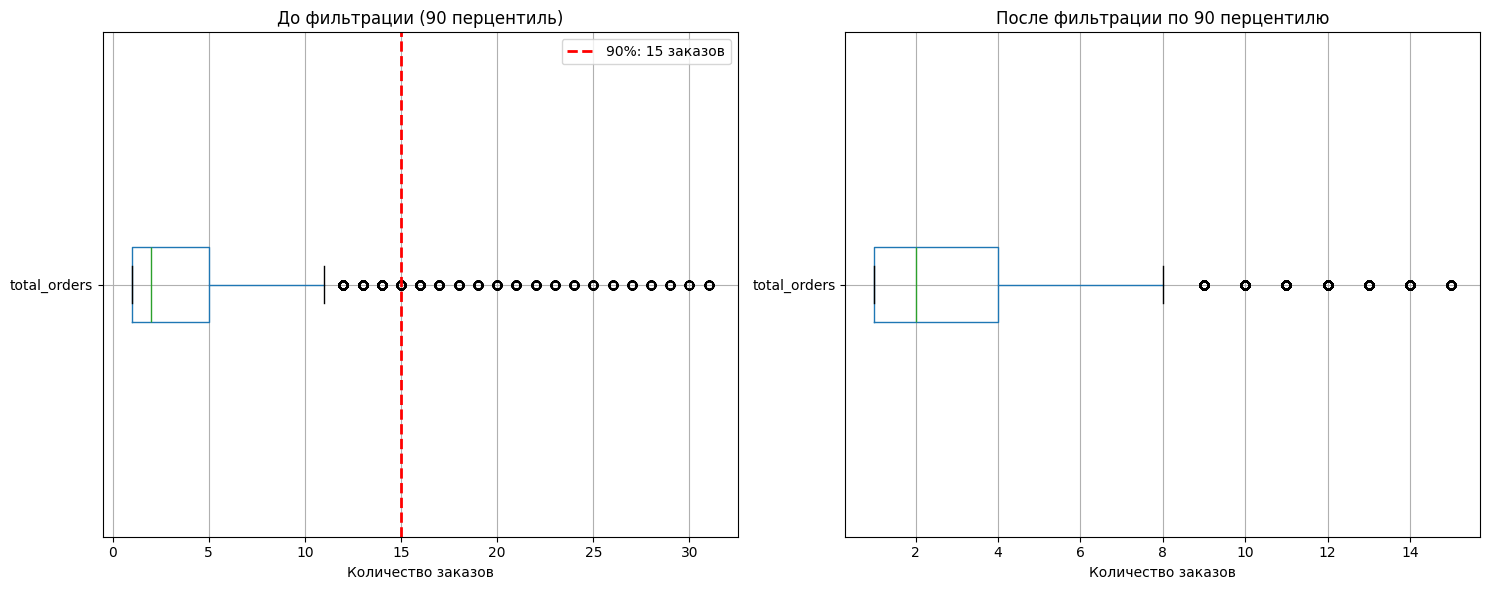

In [74]:
# 3. Графики для 90 перцентиля
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# До фильтрации с 90 перцентилем (используем график после фильтрации по 95 перцентилю)
user_profile_filtered_95.boxplot(column='total_orders', vert=False, ax=ax1)
ax1.axvline(orders_90, color='red', linestyle='--', linewidth=2, label=f'90%: {orders_90:.0f} заказов')
ax1.set_title('До фильтрации (90 перцентиль)')
ax1.set_xlabel('Количество заказов')
ax1.legend()

# После фильтрации по 90 перцентилю (без линии перцентиля)
user_profile_filtered_90.boxplot(column='total_orders', vert=False, ax=ax2)
ax2.set_title('После фильтрации по 90 перцентилю')
ax2.set_xlabel('Количество заказов')

plt.tight_layout()
plt.show()

Создадим сводную таблицу для сравнения ключевых метрик до и после фильтрации по разным перцентилям, чтобы оценить влияние выбросов на статистики и выбрать оптимальный порог фильтрации.

In [75]:
# Сводная таблица сравнения
comparison_data = {
    'Метрика': [
        'Количество пользователей',
        'Доля от исходных данных',
        'Среднее число заказов',
        'Медиана заказов', 
        '90-й перцентиль заказов',
        'Максимальное число заказов',
        'Средняя выручка за заказ',
        'Доля пользователей с 2+ заказами',
        'Доля пользователей с 5+ заказами'
    ],
    'без фильтра': [
        f"{len(user_profile):,}",
        "100.0%",
        f"{user_profile['total_orders'].mean():.2f}",
        f"{user_profile['total_orders'].median():.0f}",
        f"{user_profile['total_orders'].quantile(0.9):.0f}",
        f"{user_profile['total_orders'].max():,}",
        f"{user_profile['avg_revenue_rub'].mean():.2f}",
        f"{user_profile['is_two'].mean()*100:.1f}%",
        f"{user_profile['is_five'].mean()*100:.1f}%"
    ],
    '99%': [
        f"{len(user_profile_filtered_99):,}",
        f"{len(user_profile_filtered_99)/len(user_profile)*100:.1f}%",
        f"{user_profile_filtered_99['total_orders'].mean():.2f}",
        f"{user_profile_filtered_99['total_orders'].median():.0f}",
        f"{user_profile_filtered_99['total_orders'].quantile(0.9):.0f}",
        f"{user_profile_filtered_99['total_orders'].max():.0f}",
        f"{user_profile_filtered_99['avg_revenue_rub'].mean():.2f}",
        f"{user_profile_filtered_99['is_two'].mean()*100:.1f}%",
        f"{user_profile_filtered_99['is_five'].mean()*100:.1f}%"
    ],
    '95%': [
        f"{len(user_profile_filtered_95):,}",
        f"{len(user_profile_filtered_95)/len(user_profile)*100:.1f}%",
        f"{user_profile_filtered_95['total_orders'].mean():.2f}",
        f"{user_profile_filtered_95['total_orders'].median():.0f}",
        f"{user_profile_filtered_95['total_orders'].quantile(0.9):.0f}",
        f"{user_profile_filtered_95['total_orders'].max():.0f}",
        f"{user_profile_filtered_95['avg_revenue_rub'].mean():.2f}",
        f"{user_profile_filtered_95['is_two'].mean()*100:.1f}%",
        f"{user_profile_filtered_95['is_five'].mean()*100:.1f}%"
    ],
    '90%': [
        f"{len(user_profile_filtered_90):,}",
        f"{len(user_profile_filtered_90)/len(user_profile)*100:.1f}%",
        f"{user_profile_filtered_90['total_orders'].mean():.2f}",
        f"{user_profile_filtered_90['total_orders'].median():.0f}",
        f"{user_profile_filtered_90['total_orders'].quantile(0.9):.0f}",
        f"{user_profile_filtered_90['total_orders'].max():.0f}",
        f"{user_profile_filtered_90['avg_revenue_rub'].mean():.2f}",
        f"{user_profile_filtered_90['is_two'].mean()*100:.1f}%",
        f"{user_profile_filtered_90['is_five'].mean()*100:.1f}%"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

                         Метрика без фильтра    99%    95%    90%
        Количество пользователей      21,831 21,612 20,741 19,702
         Доля от исходных данных      100.0%  99.0%  95.0%  90.2%
           Среднее число заказов       13.16   6.48   4.05   3.12
                 Медиана заказов           2      2      2      2
         90-й перцентиль заказов          15     14     10      8
      Максимальное число заказов      10,155    151     31     15
        Средняя выручка за заказ      544.80 545.10 547.06 547.57
Доля пользователей с 2+ заказами       61.7%  61.3%  59.7%  57.6%
Доля пользователей с 5+ заказами       29.0%  28.3%  25.3%  21.3%


**Вывод: фильтрация по 99-му перцентилю — оптимальный выбор**

Сравнение различных порогов фильтрации показывает:

**Преимущества 99-го перцентиля:**
- Сохраняет 99% пользователей (21,612 из 21,831)
- Устраняет экстремальные выбросы (максимум с 10,155 до 151 заказов)
- Минимально влияет на ключевые метрики лояльности:
  - 2+ заказов: 61.7% → 61.3% (-0.4%)
  - 5+ заказов: 29.0% → 28.3% (-0.7%)
- Стабильный средний чек: 544.80 → 545.10 руб

**Нормализация статистик:**
- Среднее число заказов снижается с 13.16 до 6.48
- Приводит статистики в соответствие с реальным поведением (медиана = 2 заказа)

**Решение:** Используем user_profile_filtered_99 для дальнейшего анализа. Данные теперь репрезентативны, стабильны и готовы для сегментации и исследования лояльности.

# 4. Исследовательский анализ данных

## 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

### 4.1.1. Распределение пользователей по признакам

Создадим функцию для анализа распределения пользователей по сегментам с выводом всех категорий и их долей для выявления доминирующих "точек входа".

In [76]:
# Анализ с выводом всех сегментов
def segment_analysis(profile_df, column_name, segment_name):
    print(f"\n{segment_name}:")
    print("-" * 40)
    
    counts = profile_df[column_name].value_counts()
    pct = profile_df[column_name].value_counts(normalize=True) * 100
    
    # Все сегменты
    all_segments = pd.DataFrame({
        'Сегмент': counts.index,
        'Пользователей': counts.values,
        'Доля %': pct.round(1)
    })
    
    print(f"Всего сегментов: {len(counts)}")
    print(f"Все сегменты:")
    print(all_segments.to_string(index=False))

Применим функцию анализа сегментов к ключевым характеристикам первого заказа: типу мероприятия, устройству, региону и билетному оператору.

In [77]:
segment_analysis(user_profile_filtered_99, 'first_event_type', 'Тип первого мероприятия')
segment_analysis(user_profile_filtered_99, 'first_device', 'Тип устройства, с которого совершена первая покупка')
segment_analysis(user_profile_filtered_99, 'first_region', 'Регион проведения мероприятия из первого заказа')
segment_analysis(user_profile_filtered_99, 'first_service', 'Билетный оператор, продавшеий билеты на первый заказ')


Тип первого мероприятия:
----------------------------------------
Всего сегментов: 7
Все сегменты:
 Сегмент  Пользователей  Доля %
концерты           9562    44.2
  другое           5393    25.0
   театр           4245    19.6
 стендап           1110     5.1
   спорт            794     3.7
выставки            413     1.9
    ёлки             95     0.4

Тип устройства, с которого совершена первая покупка:
----------------------------------------
Всего сегментов: 2
Все сегменты:
Сегмент  Пользователей  Доля %
 mobile          17901    82.8
desktop           3711    17.2

Регион проведения мероприятия из первого заказа:
----------------------------------------
Всего сегментов: 81
Все сегменты:
                  Сегмент  Пользователей  Доля %
       Каменевский регион           7086    32.8
     Североярская область           3760    17.4
      Широковская область           1224     5.7
         Озернинский край            675     3.1
     Малиновоярский округ            526     2.4
    

**Вывод: распределение пользователей по сегментам показывает высокую концентрацию**

Анализ выявил резкую неравномерность распределения по всем признакам:

**Тип первого мероприятия:**
- Топ-3 категории (`концерты` 44.2%, `другое` 25.0%, `театр` 19.6%) охватывают 88.8% пользователей
- Категория `другое` сохраняет значительную долю даже после фильтрации

**Тип устройства:**
- Явное доминирование `mobile` (82.8%) над `desktop` (17.2%)

**Региональное распределение:**
- Высокая концентрация: топ-3 региона дают 55.9% пользователей
- `Каменевский регион` alone - 32.8% (каждый третий пользователь)
- Длинный хвост из малых регионов (78 регионов с долей <1%)

**Билетные операторы:**
- Умеренная концентрация: топ-5 операторов охватывают 72.5%
- Лидер: `Билеты без проблем` (23.9%) без абсолютного доминирования

Данные демонстрируют типичную для маркетплейсов структуру с выраженными "точками входа".

Визуализируем распределение пользователей по типам первого мероприятия с помощью горизонтальной столбчатой диаграммы для наглядного представления доминирующих категорий.

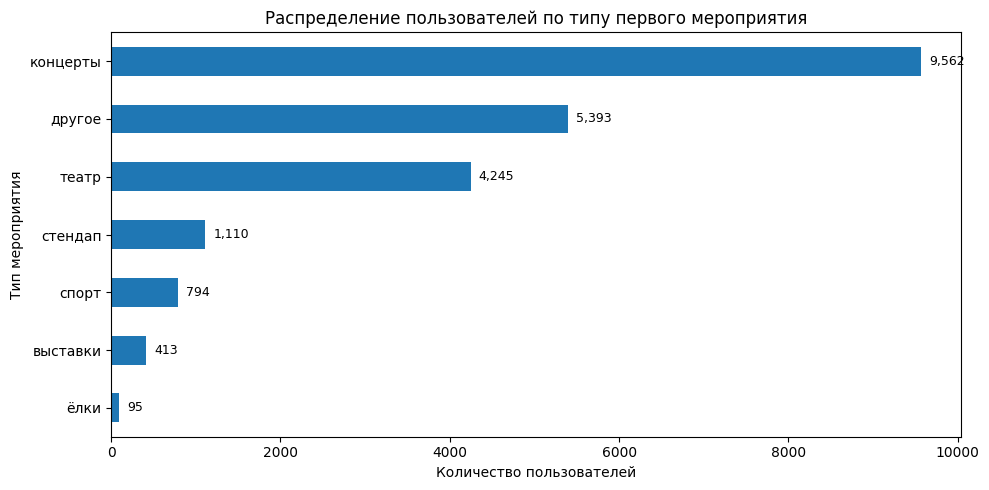

In [78]:
# Делаем стандартный стиль с белым фоном
plt.style.use('default')

# Визуализация типа первого мероприятия
plt.figure(figsize=(10, 5))

# Сохраняем данные для графика в переменную
value_counts = user_profile_filtered_99['first_event_type'].value_counts().sort_values(ascending=True)

# Строим столбчатую диаграмму
value_counts.plot(
    kind='barh',
    rot=0,
    legend=False,
    title='Распределение пользователей по типу первого мероприятия',
    color='#1f77b4'
)

# Настраиваем оформление
plt.xlabel('Количество пользователей')
plt.ylabel('Тип мероприятия')

# Убираем серый фон у области графика
ax = plt.gca()
ax.set_facecolor('white')

# Добавляем значения на концах столбцов
for i, v in enumerate(value_counts):
    ax.text(v + max(value_counts)*0.01, i, f'{v:,}', va='center', fontsize=9)

# Автоматическая подгонка
plt.tight_layout()

# Выводим график
plt.show()

Визуализируем распределение пользователей по типам устройств первого заказа, подчеркивая значительное преобладание мобильных устройств над десктопными.

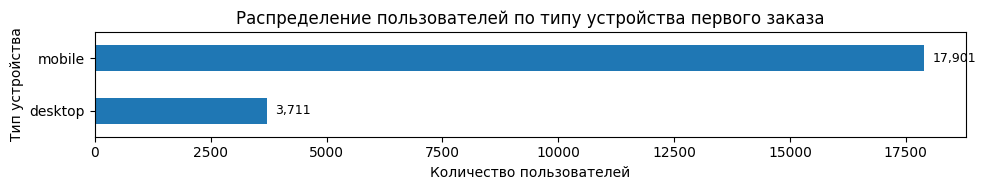

In [79]:
# Делаем стандартный стиль с белым фоном
plt.style.use('default')

# Визуализация типа устройства
plt.figure(figsize=(10, 2))

# Сохраняем данные для графика в переменную
value_counts = user_profile_filtered_99['first_device'].value_counts().sort_values(ascending=True)

# Строим столбчатую диаграмму
value_counts.plot(
    kind='barh',
    rot=0,
    legend=False,
    title='Распределение пользователей по типу устройства первого заказа',
    color='#1f77b4'
)

# Настраиваем оформление
plt.xlabel('Количество пользователей')
plt.ylabel('Тип устройства')

# Убираем серый фон у области графика
ax = plt.gca()
ax.set_facecolor('white')

# Добавляем значения на концах столбцов
for i, v in enumerate(value_counts):
    ax.text(v + max(value_counts)*0.01, i, f'{v:,}', va='center', fontsize=9)

# Автоматическая подгонка
plt.tight_layout()

# Выводим график
plt.show()

Визуализируем распределение пользователей по регионам первого заказа, используя вертикальную диаграмму большого размера для отображения всех 81 региона с их долями.

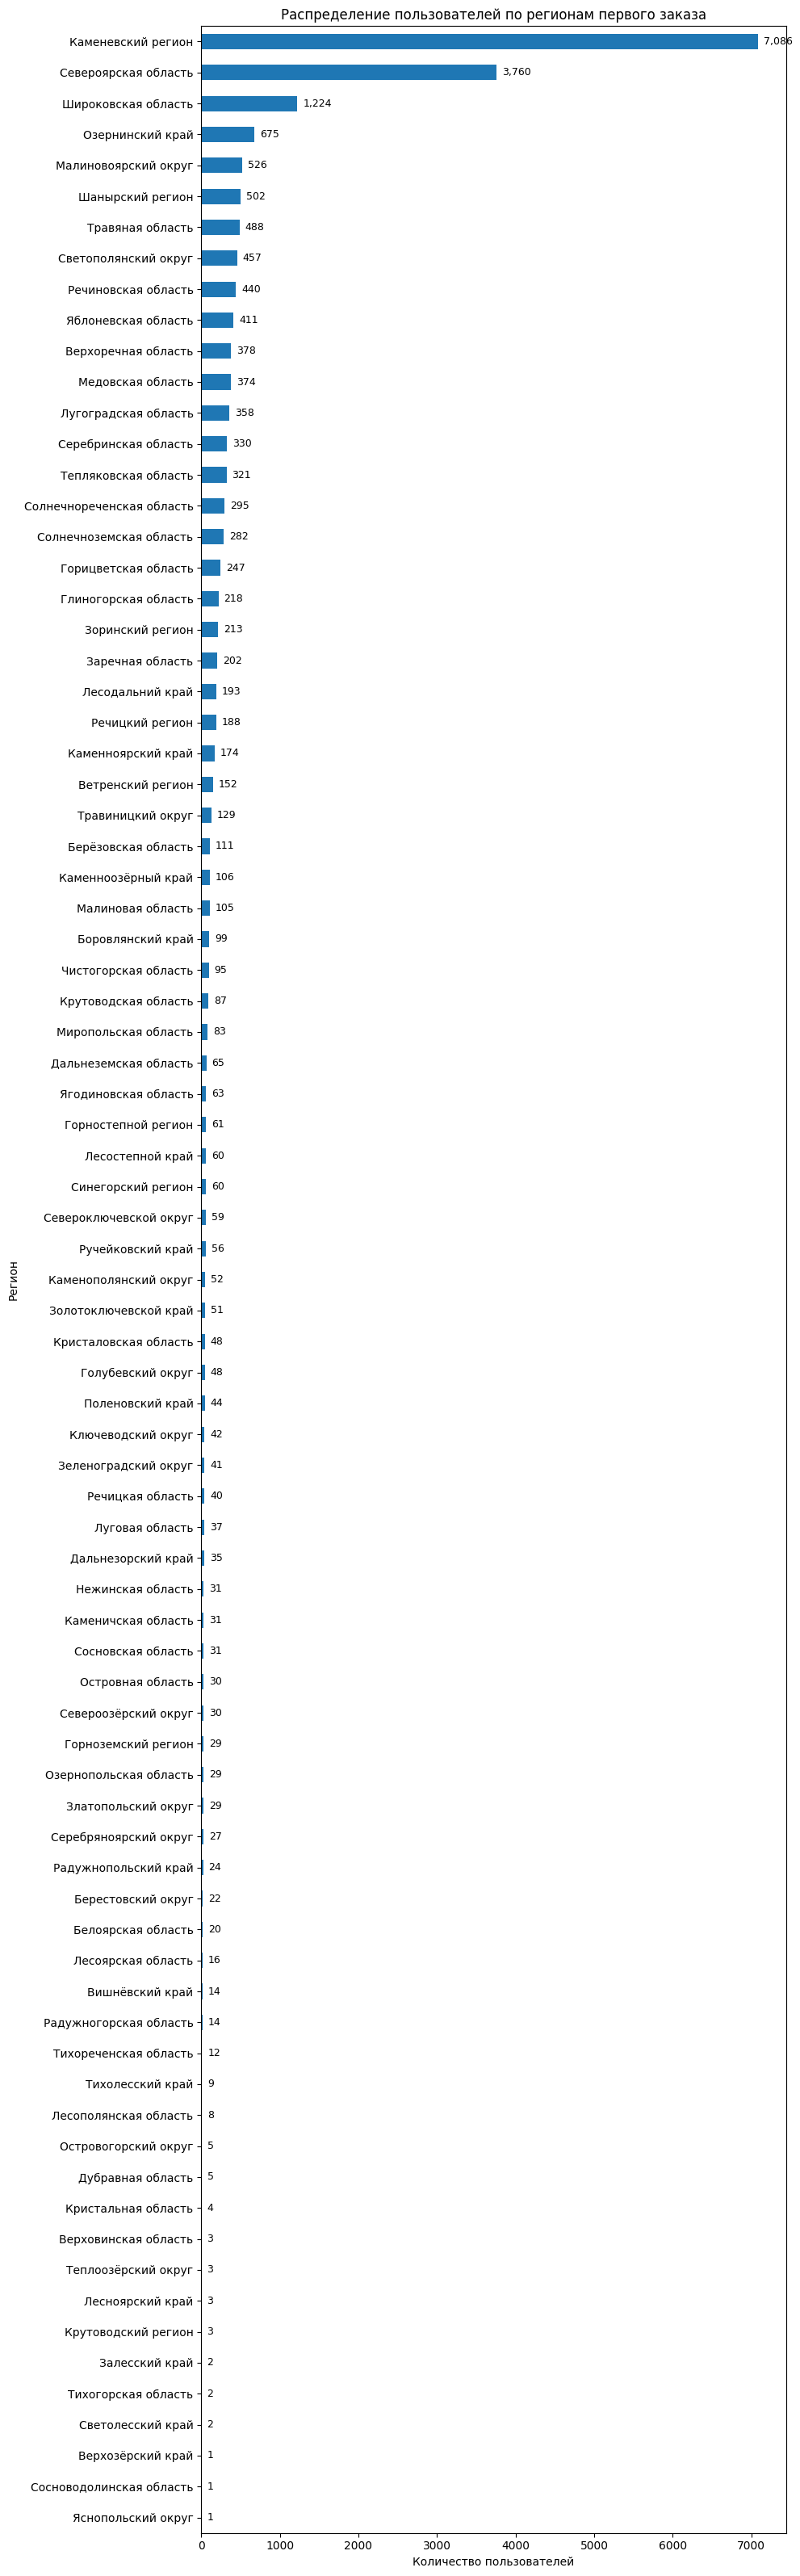

In [80]:
# Делаем стандартный стиль с белым фоном
plt.style.use('default')

# Визуализация регионов
plt.figure(figsize=(10, 32))

# Сохраняем данные для графика в переменную
value_counts = user_profile_filtered_99['first_region'].value_counts().sort_values(ascending=True)

# Строим столбчатую диаграмму
value_counts.plot(
    kind='barh',
    rot=0,
    legend=False,
    title='Распределение пользователей по регионам первого заказа',
    color='#1f77b4'
)

# Настраиваем оформление
plt.xlabel('Количество пользователей')
plt.ylabel('Регион')

# Убираем серый фон у области графика
ax = plt.gca()
ax.set_facecolor('white')

# Добавляем значения на концах столбцов
for i, v in enumerate(value_counts):
    ax.text(v + max(value_counts)*0.01, i, f'{v:,}', va='center', fontsize=9)

# Автоматическая подгонка
plt.tight_layout()

# Выводим график
plt.show()

Визуализируем распределение пользователей по билетным операторам первого заказа, демонстрируя структуру рынка с лидирующими игроками и длинным хвостом мелких операторов.

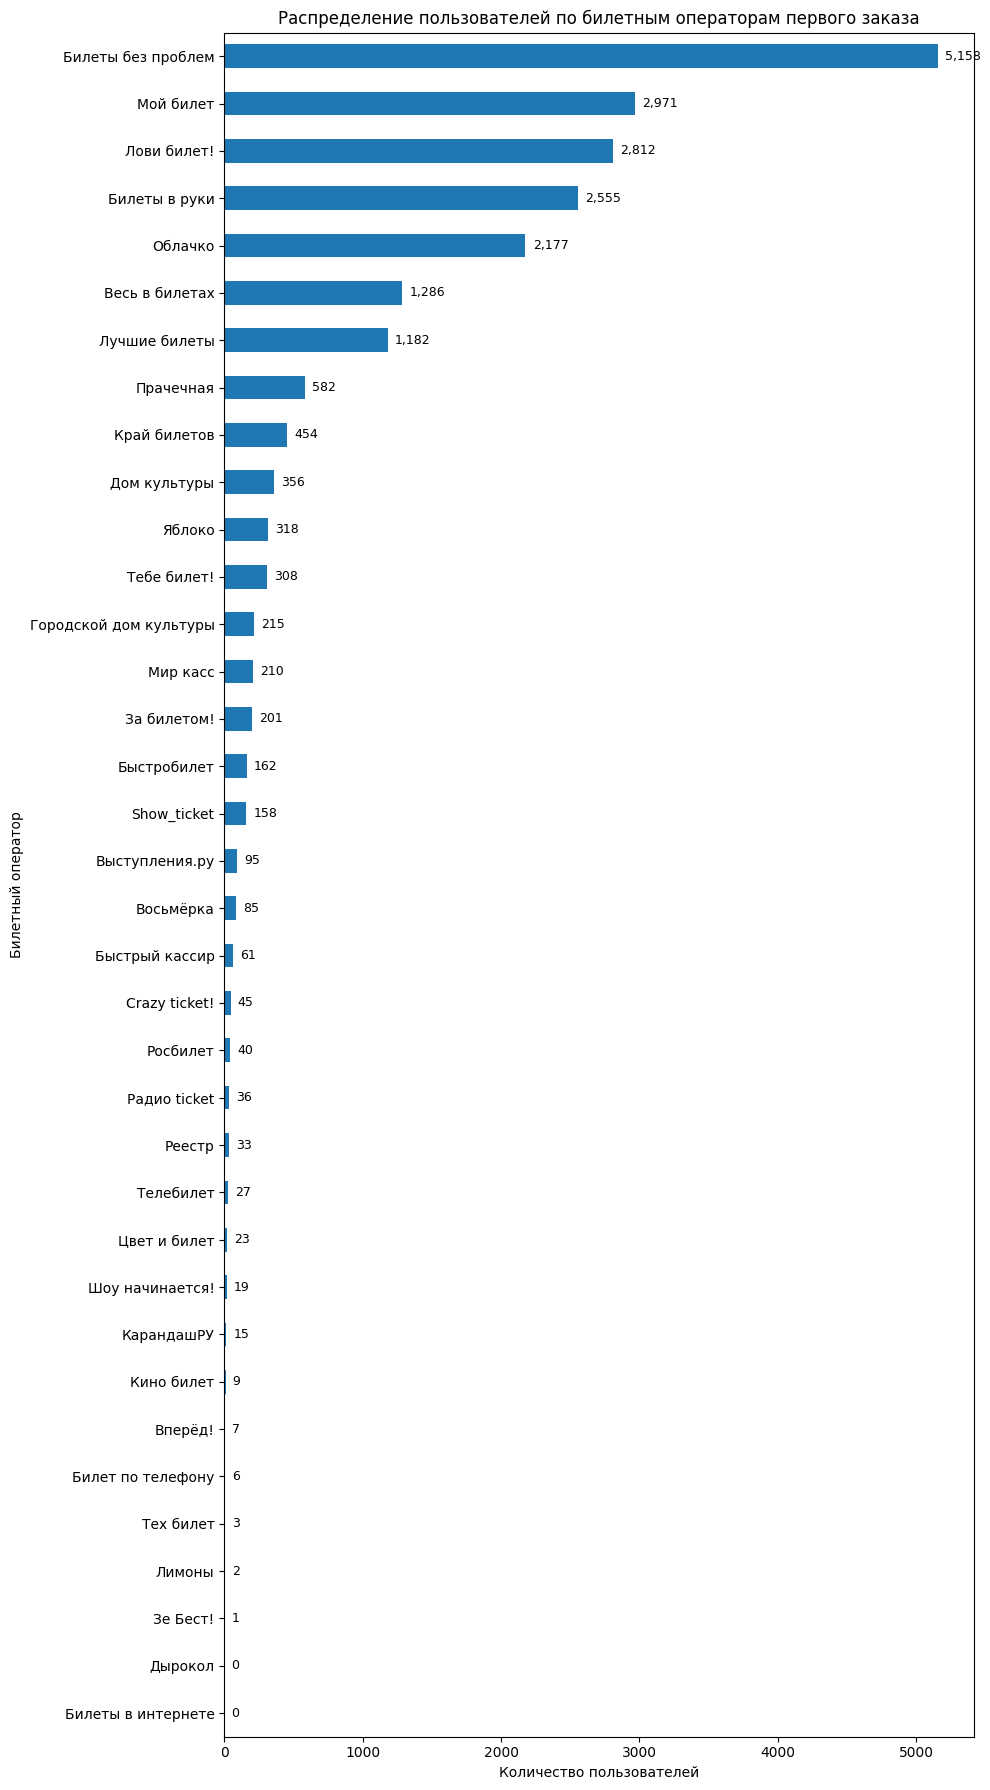

In [81]:
# Делаем стандартный стиль с белым фоном
plt.style.use('default')

# Визуализация билетных операторов
plt.figure(figsize=(10, 18))

# Сохраняем данные для графика в переменную
value_counts = user_profile_filtered_99['first_service'].value_counts().sort_values(ascending=True)

# Строим столбчатую диаграмму
value_counts.plot(
    kind='barh',
    rot=0,
    legend=False,
    title='Распределение пользователей по билетным операторам первого заказа',
    color='#1f77b4'
)

# Настраиваем оформление
plt.xlabel('Количество пользователей')
plt.ylabel('Билетный оператор')

# Убираем серый фон у области графика
ax = plt.gca()
ax.set_facecolor('white')

# Добавляем значения на концах столбцов
for i, v in enumerate(value_counts):
    ax.text(v + max(value_counts)*0.01, i, f'{v:,}', va='center', fontsize=9)

# Автоматическая подгонка
plt.tight_layout()

# Выводим график
plt.show()

**Вывод: выявлены четко выраженные "точки входа" пользователей**

Распределение пользователей по ключевым признакам показывает резкую неравномерность:

**Высокая концентрация по типам мероприятий:**
- 88,8% приходится на топ-3 сегмента
- Лидируют `концерты` (44,2%), `другое` (25,0%), `театр` (19,6%)

**Доминирование мобильных устройств:**
- 82,8% заказов совершается с `mobile` устройств

**Региональная концентрация:**
- 55,8% пользователей из трех регионов
- `Каменевский регион` alone - 32,8% (каждый третий пользователь)
- 72% пользователей из топ-10 регионов при наличии 81 региона в базе

**Структура билетных операторов:**
- Топ-5 операторов охватывают 72,5%
- Лидер - `Билеты без проблем` (23,9%) без абсолютной монополии

**Ключевые точки входа:** Mobile (82,8%) | Концерты (44,2%) | Каменевский регион (32,8%) | Билеты без проблем (23,9%)

Поведение новой аудитории сильно сконцентрировано вокруг нескольких доминирующих категорий, что указывает на узкие, но мощные каналы привлечения и типичные сценарии первого взаимодействия с платформой.

## 4.1.2. Возвраты пользователей

Создадим функцию для анализа лояльности по сегментам с использованием порогов сегментации по числу пользователей, отражающих уровни статистической надёжности:

- **≥1000 пользователей** — высокая надёжность
- **≥100 пользователей** — средняя надёжность  
- **≥30 пользователей** — минимальная надёжность

Эти пороги позволяют корректно интерпретировать данные в зависимости от целей анализа и избегать выводов на основе малых выборок.

In [82]:
def segment_loyalty_analysis(profile_df, column_name, segment_name):
    """
    Анализ лояльности по сегментам с учетом статистической надежности
    """
    print(f"\n{segment_name}:")
    print("-" * 40)
    
    # Группируем и считаем метрики лояльности
    loyalty_stats = profile_df.groupby(column_name, observed=True).agg({
        'total_orders': 'count',
        'is_two': ['sum', 'mean']
    }).round(3)
    
    loyalty_stats.columns = ['users_total', 'users_2plus', 'loyalty_rate']
    loyalty_stats['loyalty_pct'] = (loyalty_stats['loyalty_rate'] * 100).round(1)
    
    # Определяем надежность сегментов (исправленная цветовая схема)
    def get_reliability(users_count):
        if users_count >= 1000: return "🟢 Высокая"      # Зеленая
        elif users_count >= 100: return "🟡 Средняя"     # Желтая
        elif users_count >= 30: return "🔴 Минимальная"  # Красная
        else: return "⚪ Низкая"                         # Белая
    
    # Фильтруем надежные сегменты (100+ пользователей)
    reliable_segments = loyalty_stats[loyalty_stats['users_total'] >= 100].copy()
    reliable_segments['Надежность'] = reliable_segments['users_total'].apply(get_reliability)
    
    if len(reliable_segments) > 0:
        reliable_segments = reliable_segments.sort_values('loyalty_pct', ascending=False)
        
        result_df = pd.DataFrame({
            'Сегмент': reliable_segments.index,
            'Всего_пользователей': reliable_segments['users_total'],
            'Лояльных_2+': reliable_segments['users_2plus'],
            'Доля_лояльных_%': reliable_segments['loyalty_pct'],
            'Надежность': reliable_segments['Надежность']
        })
        
        print(f"Надежные сегменты (100+ пользователей): {len(reliable_segments)} из {len(loyalty_stats)}")
        print(result_df.to_string(index=False))
        
        # Ключевые инсайты
        best = result_df.iloc[0]
        worst = result_df.iloc[-1]
        
        print(f"\nКлючевые инсайты:")
        print(f"• Самый лояльный: {best['Сегмент']} ({best['Доля_лояльных_%']}%)")
        print(f"• Наименее лояльный: {worst['Сегмент']} ({worst['Доля_лояльных_%']}%)")
        print(f"• Разница: {best['Доля_лояльных_%'] - worst['Доля_лояльных_%']:.1f}%")
        
    else:
        print("Нет сегментов с достаточным количеством пользователей для анализа")
    
    # Возвращаем None чтобы избежать автоматического вывода в Jupyter
    return None

Применим функцию анализа лояльности к ключевым характеристикам первого заказа для выявления сегментов с наибольшей вероятностью возврата пользователей.

In [83]:
segment_loyalty_analysis(user_profile_filtered_99, 'first_event_type', 'Тип первого мероприятия')
segment_loyalty_analysis(user_profile_filtered_99, 'first_device', 'Тип устройства, с которого совершена первая покупка')
segment_loyalty_analysis(user_profile_filtered_99, 'first_region', 'Регион проведения мероприятия из первого заказа')
segment_loyalty_analysis(user_profile_filtered_99, 'first_service', 'Билетный оператор, продавшеий билеты на первый заказ')


Тип первого мероприятия:
----------------------------------------
Надежные сегменты (100+ пользователей): 6 из 7
 Сегмент  Всего_пользователей  Лояльных_2+  Доля_лояльных_% Надежность
выставки                  413          265             64.2  🟡 Средняя
   театр                 4245         2693             63.4  🟢 Высокая
концерты                 9562         5910             61.8  🟢 Высокая
 стендап                 1110          676             60.9  🟢 Высокая
  другое                 5393         3210             59.5  🟢 Высокая
   спорт                  794          443             55.8  🟡 Средняя

Ключевые инсайты:
• Самый лояльный: выставки (64.2%)
• Наименее лояльный: спорт (55.8%)
• Разница: 8.4%

Тип устройства, с которого совершена первая покупка:
----------------------------------------
Надежные сегменты (100+ пользователей): 2 из 2
Сегмент  Всего_пользователей  Лояльных_2+  Доля_лояльных_% Надежность
desktop                 3711         2369             63.8  🟢 Высокая
 m

**Вывод: выявлены сегменты с максимальной лояльностью пользователей**

Анализ лояльности по надежным сегментам (100+ пользователей) показывает:

**Наиболее лояльные сегменты:**
- **Тип мероприятия**: `выставки` (64.2%), `театр` (63.4%), `концерты` (61.8%)
- **Устройство**: `desktop` (63.8%) лояльнее `mobile` (60.8%)
- **Регионы**: `Шанырский регион` (67.3%), `Горицветская область` (66.8%)
- **Операторы**: `Show_ticket` (65.2%), `Край билетов` (65.2%), `Дом культуры` (64.6%)

**Наименее лояльные:**
- **Мероприятия**: `спорт` (55.8%)
- **Регионы**: `Глиногорская область` (53.7%)
- **Операторы**: `Яблоко` (53.5%)

**Ключевой инсайт**: Наибольший потенциал удержания у пользователей, совершающих первую покупку на выставки, через desktop, в топ-регионах и у специализированных операторов.

Создадим универсальную функцию для визуализации лояльности пользователей с помощью пузырьковых диаграмм. Функция будет отображать связь между размером сегмента (количество пользователей) и уровнем лояльности, выделяя сегменты выше и ниже среднего разными цветами.

In [84]:
def create_bubble_chart(data, category_col, title, top_n=None, size_multiplier=2):
    """Универсальная функция для создания пузырьковых диаграмм лояльности"""
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Подготовка данных
    plot_data = (data.groupby(category_col, observed=True)
                 .agg(total_orders=('total_orders', 'count'), 
                      is_two=('is_two', 'mean'))
                 .query('total_orders >= 100')
                 .assign(loyalty_pct=lambda x: x['is_two'] * 100,
                         size=lambda x: x['total_orders'] * size_multiplier))
    
    if top_n:
        plot_data = plot_data.nlargest(top_n, 'is_two')
    
    avg_loyalty = plot_data['loyalty_pct'].mean()
    colors = ['#1f77b4' if x > avg_loyalty else '#e74c3c' for x in plot_data['loyalty_pct']]
    
    # Построение графика
    ax.scatter(plot_data['total_orders'], plot_data['loyalty_pct'], 
               s=plot_data['size'], c=colors, alpha=0.7, edgecolors='black')
    
    ax.axhline(avg_loyalty, color='red', linestyle='--', alpha=0.8)
    ax.set(xlabel='Количество пользователей', 
           ylabel='Доля лояльных пользователей, %', 
           title=title,
           facecolor='white')
    ax.grid(True, alpha=0.3)
    
    # Добавление подписей
    for _, row in plot_data.iterrows():
        label = f"{row.name[:15]}...\n({row.loyalty_pct:.1f}%)" if len(str(row.name)) > 15 else f"{row.name}\n({row.loyalty_pct:.1f}%)"
        ax.annotate(label, (row.total_orders, row.loyalty_pct),
                    xytext=(10, 10), textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9),
                    arrowprops=dict(arrowstyle='->', color='gray', alpha=0.6))
    
    # Легенда
    from matplotlib.patches import Patch
    ax.legend(handles=[
        Patch(facecolor='#1f77b4', label='Выше среднего', alpha=0.7),
        Patch(facecolor='#e74c3c', label='Ниже среднего', alpha=0.7),
        plt.Line2D([0], [0], color='red', linestyle='--', label=f'Средняя: {avg_loyalty:.1f}%')
    ], loc='upper right')
    
    plt.tight_layout()
    plt.show()

Применим универсальную функцию для создания пузырьковых диаграмм лояльности по всем ключевым категориям, ограничив топ регионов и операторов 10 сегментами для лучшей читаемости.

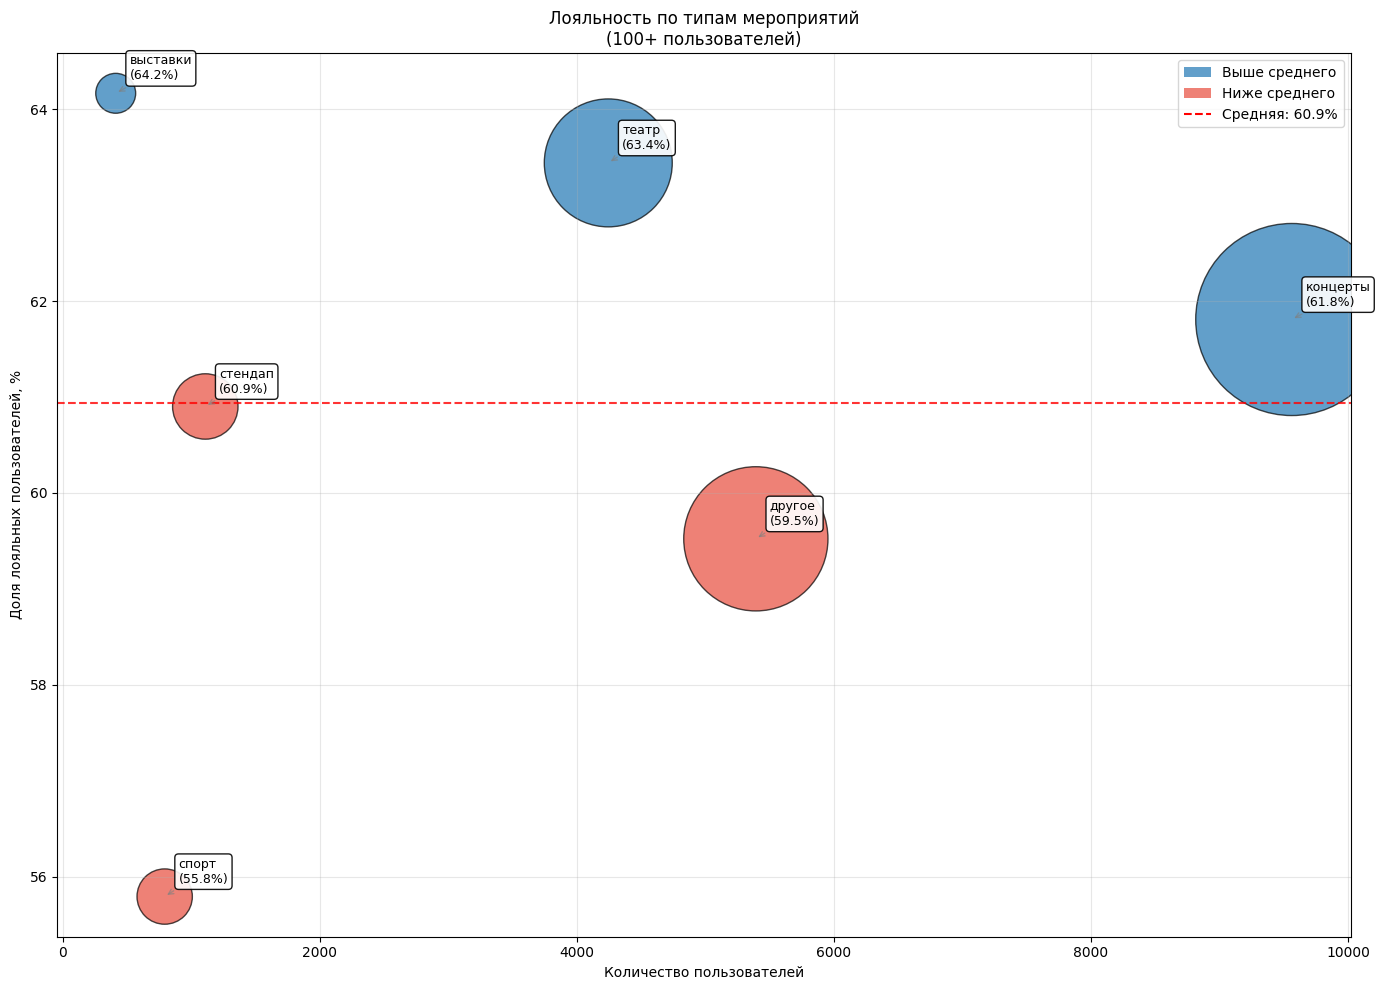

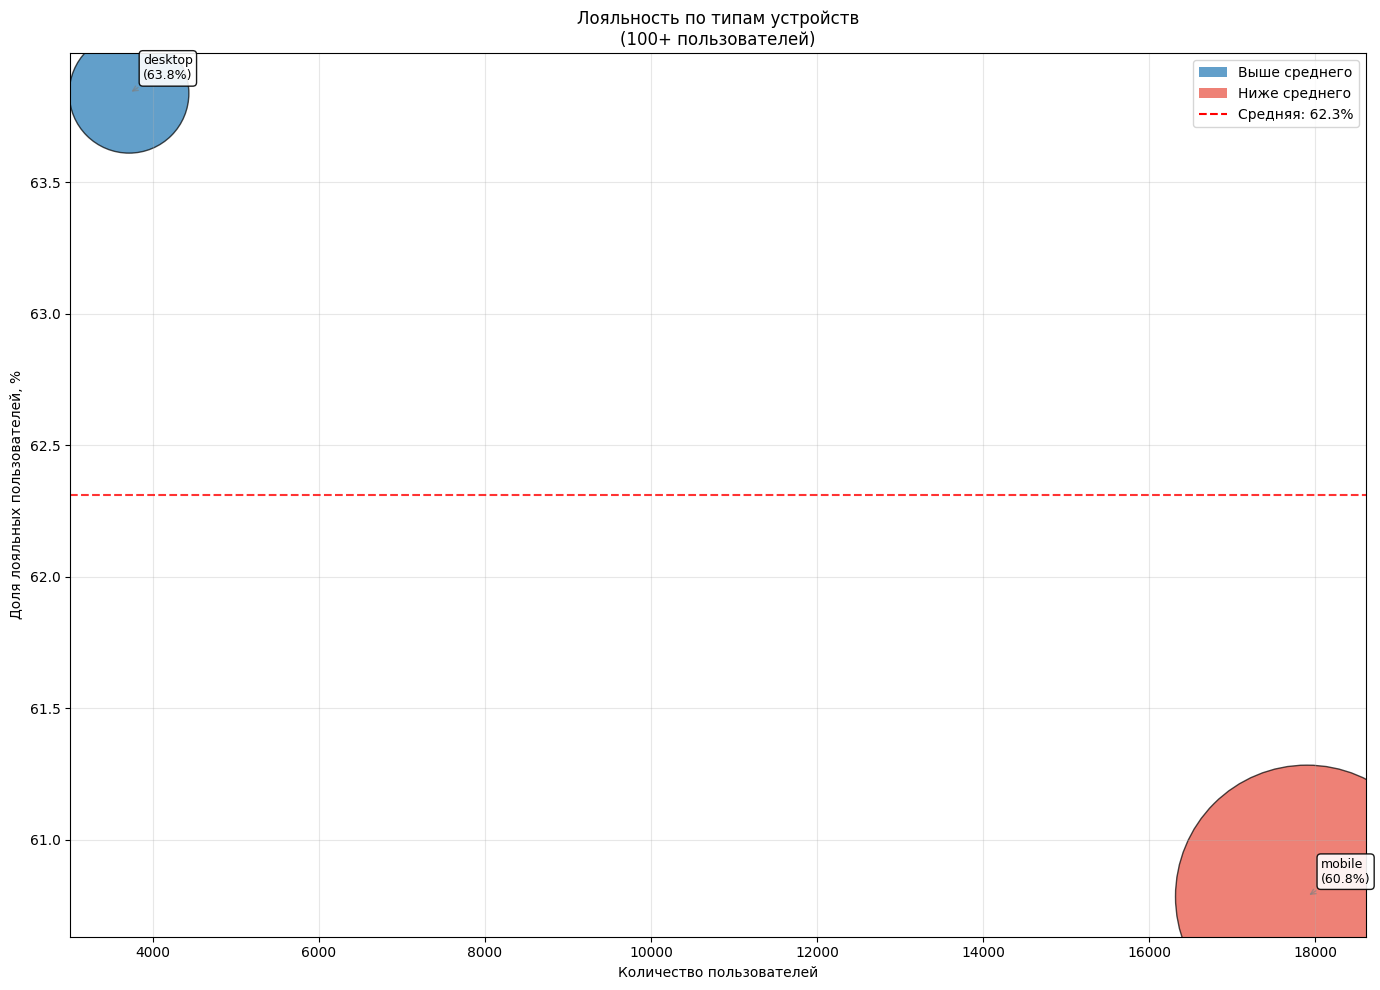

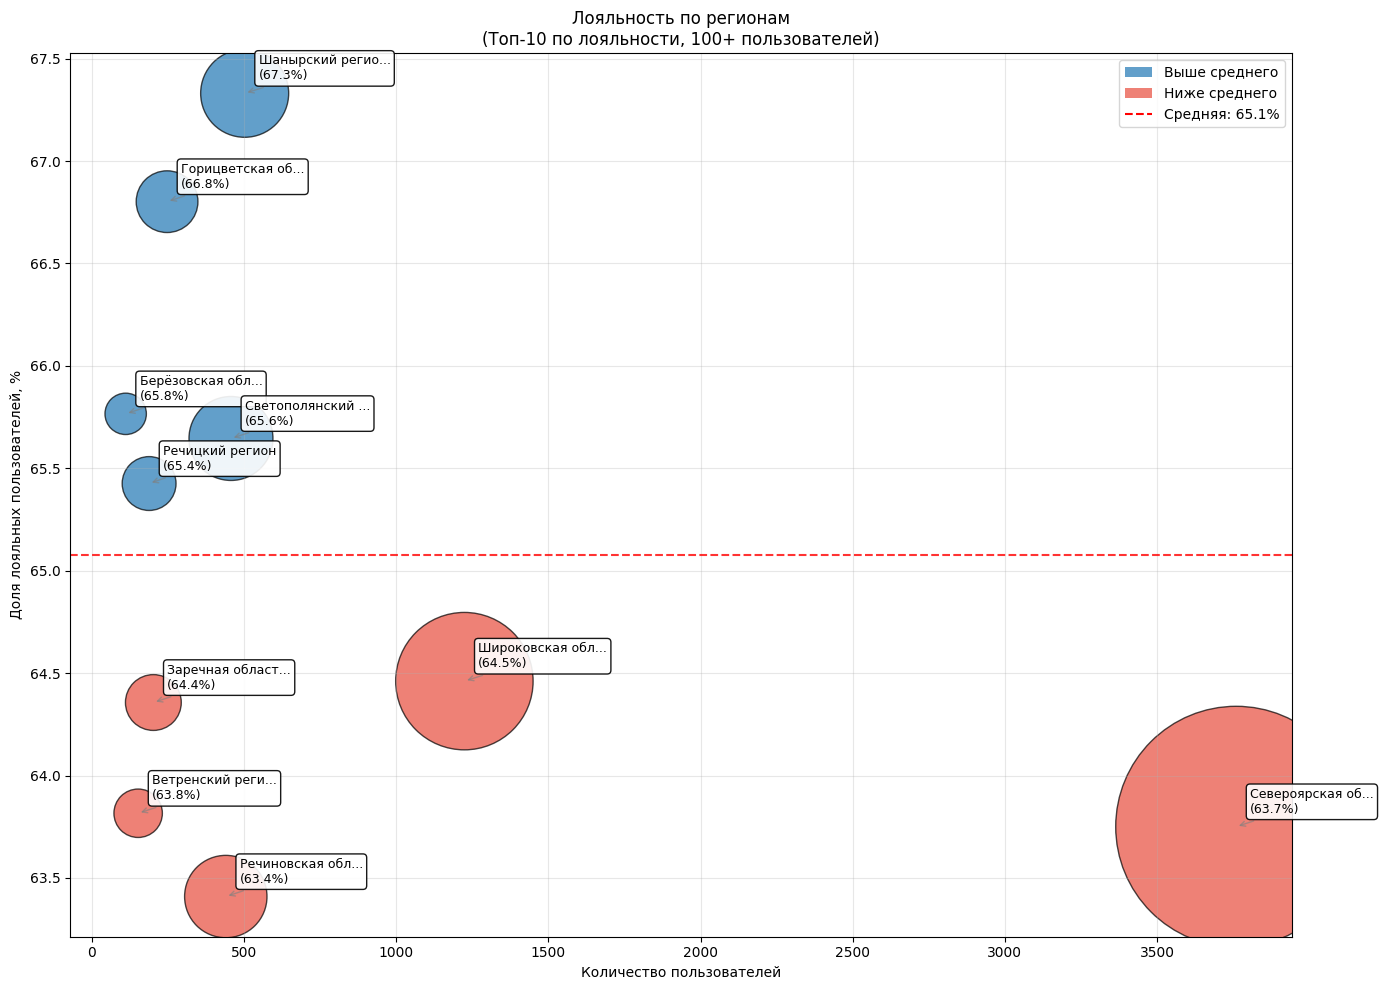

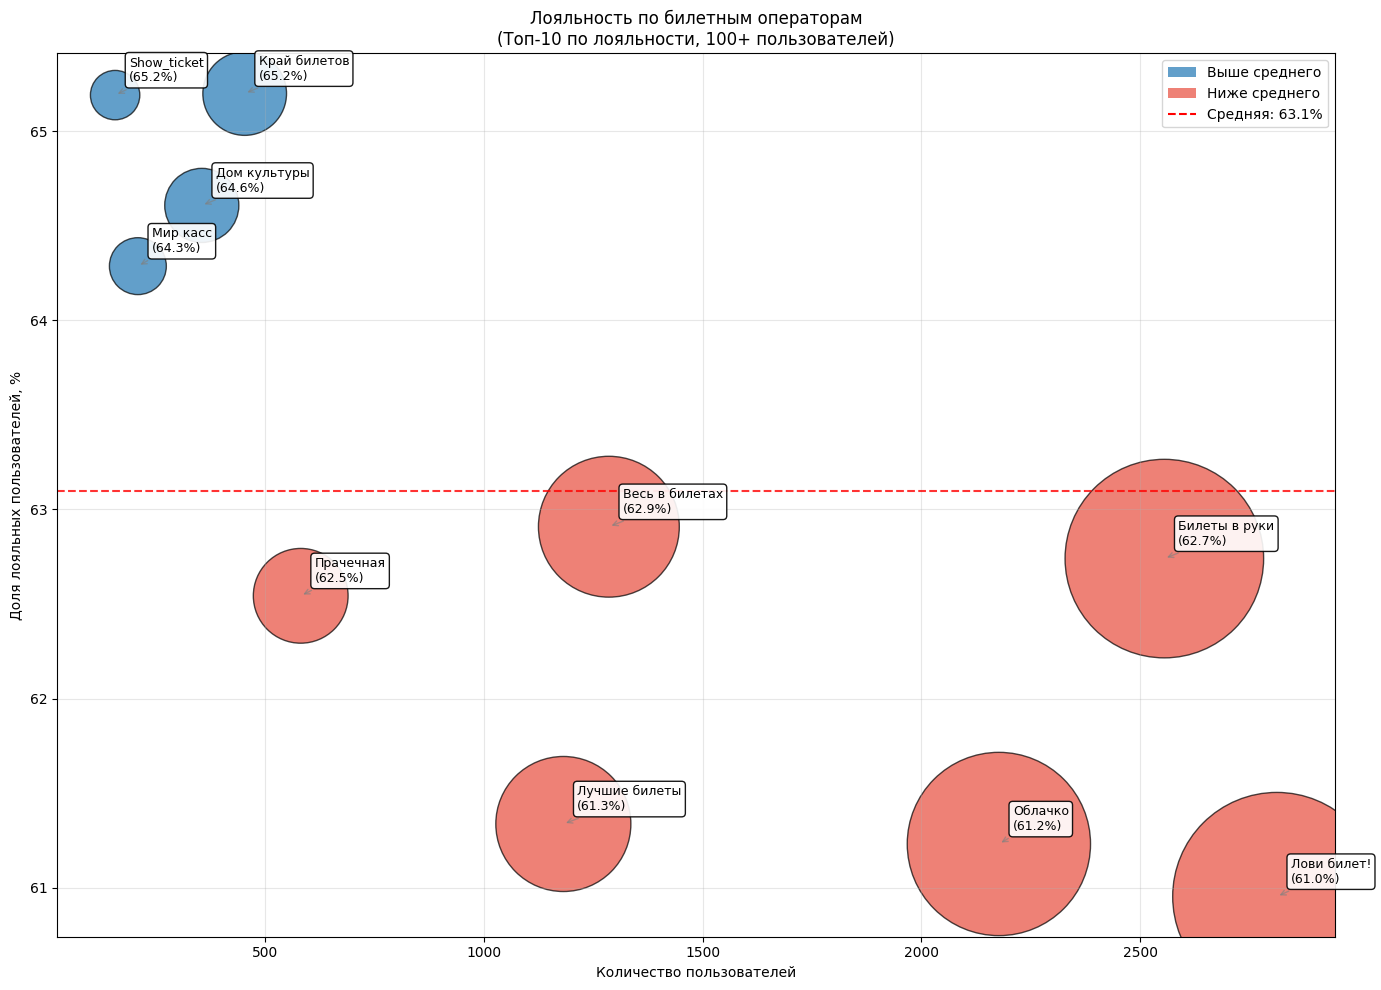

In [85]:
# Создаем все графики одной функцией
create_bubble_chart(user_profile_filtered_99, 'first_event_type', 
                   'Лояльность по типам мероприятий\n(100+ пользователей)')

create_bubble_chart(user_profile_filtered_99, 'first_device', 
                   'Лояльность по типам устройств\n(100+ пользователей)')

create_bubble_chart(user_profile_filtered_99, 'first_region', 
                   'Лояльность по регионам\n(Топ-10 по лояльности, 100+ пользователей)', 
                   top_n=10, size_multiplier=8)

create_bubble_chart(user_profile_filtered_99, 'first_service', 
                   'Лояльность по билетным операторам\n(Топ-10 по лояльности, 100+ пользователей)', 
                   top_n=10, size_multiplier=8)

**Вывод: выявлены сегменты с максимальной лояльностью пользователей**

Анализ лояльности выявил четкие закономерности:

**Наиболее лояльные сегменты:**
- **Мероприятия**: `выставки` (64.2%), `театр` (63.4%), `концерты` (61.8%)
- **Устройства**: `desktop`-пользователи (63.8%) лояльнее мобильных (60.8%)
- **Регионы**: `Шанырский регион` (67.3%), `Горицветская область` (66.8%)
- **Операторы**: `Show_ticket` и `Край билетов` (65.2%) обгоняют массового игрока `Билеты без проблем` (60.3%)

**Ключевой инсайт**: Наибольший потенциал удержания у пользователей, совершающих первую покупку на выставки, через desktop, в топ-регионах и у специализированных операторов. Эти "точки входа" сочетают высокое качество взаимодействия и вовлечённость, несмотря на меньший охват.

### 4.1.3. Проверка продуктовых гипотез

### Гипотеза 1  
**«Тип мероприятия влияет на вероятность возврата — пользователи спортивных мероприятий возвращаются чаще, чем концертов»**  
❌ **Опровержена**

**Факты:**  
- Лояльность (доля возврата) среди пользователей **концертов**: **61,8%**  
- Лояльность среди пользователей **спортивных мероприятий**: **55,8%**  
- **Разница**: **–6,0 п.п.** в пользу концертов

**Вывод:**  
Пользователи, совершившие первую покупку на **концерты**, возвращаются **значительно чаще**, чем те, кто начал со **спорта**. Более того, спортивные мероприятия демонстрируют **самую низкую лояльность** среди всех типов мероприятий.  

Гипотеза не подтверждается — наоборот, **концерты являются более эффективной «точкой входа»** с точки зрения удержания.

### Гипотеза 2  
**«В регионах с наибольшим количеством пользователей выше доля повторных заказов»**  
❌ **Опровержена**

**Факты — топ-3 региона по охвату:**  
- **Каменевский регион** (7 086 пользователей) — **62,4%** лояльности  
- **Североярская область** (3 760 пользователей) — **63,8%** лояльности  
- **Широковская область** (1 224 пользователя) — **64,5%** лояльности  

**Факты — топ-2 региона по лояльности:**  
- **Шанырский регион** (502 пользователя) — **67,3%** лояльности  
- **Горицветская область** (247 пользователей) — **66,8%** лояльности  

**Вывод:**  
Наблюдается **обратная зависимость**: регионы с **меньшей аудиторией**, но более высокой вовлечённостью (Шанырский, Горицветская) показывают **наибольшую лояльность**. Крупнейший по охвату **Каменевский регион** (32,8% всей базы) демонстрирует **более низкую лояльность**, чем топовые малые регионы.  

Гипотеза не подтверждается: **масштаб не гарантирует удержание** — наоборот, в менее охваченных регионах качество взаимодействия выше.

### Ключевые инсайты

- **Спортивные мероприятия требуют особого внимания** — демонстрируют **самый низкий уровень возврата** среди всех типов событий.  
- **Региональная стратегия должна фокусироваться на качестве, а не только на масштабе**: малые регионы (например, Шанырский, Горицветская) показывают **более высокую лояльность**, чем крупнейшие по охвату.  
- **Целесообразно изучить практики успешных малых регионов** — их подходы к вовлечению и удержанию могут быть **реплицированы в крупных регионах** для повышения общей лояльности.

## 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

### 4.2.1. Cвязь между средней выручкой сервиса с заказа и повторными заказами.

Визуализируем распределение средней выручки между пользователями с разным уровнем лояльности, сравнивая однократных и многократных покупателей для выявления паттернов в ценовом поведении.

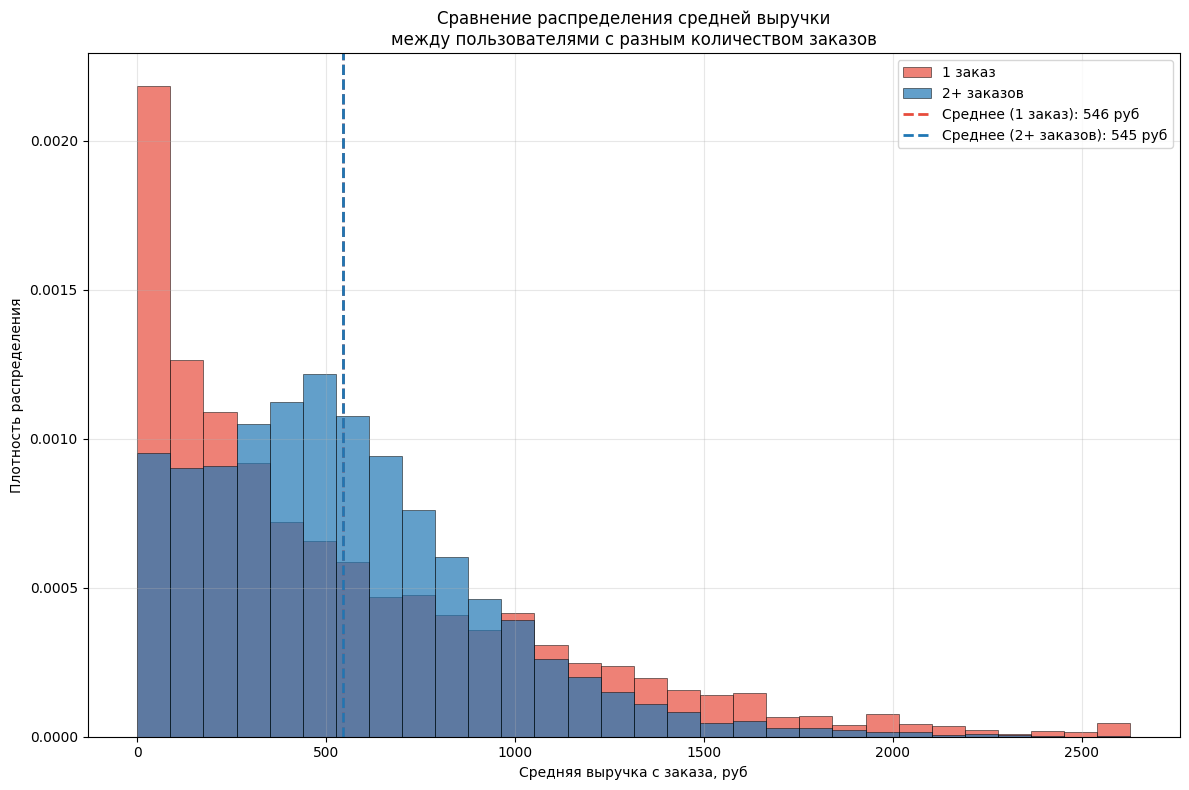

In [86]:
# Делаем стандартный стиль с белым фоном
plt.style.use('default')

# Разделяем пользователей на группы по бинарному признаку is_two
one_time_users = user_profile_filtered_99[user_profile_filtered_99['is_two'] == 0]  # Только 1 заказ
returning_users = user_profile_filtered_99[user_profile_filtered_99['is_two'] == 1]  # 2+ заказов

# Визуализация распределения средней выручки
plt.figure(figsize=(12, 8))

# Определяем одинаковые интервалы для обеих групп
bins = 30
alpha = 0.7

# Строим сравнительные гистограммы
plt.hist(one_time_users['avg_revenue_rub'], 
         bins=bins, alpha=alpha, color='#e74c3c', 
         label='1 заказ', density=True, edgecolor='black', linewidth=0.5)

plt.hist(returning_users['avg_revenue_rub'], 
         bins=bins, alpha=alpha, color='#1f77b4', 
         label='2+ заказов', density=True, edgecolor='black', linewidth=0.5)

# Настраиваем оформление
plt.xlabel('Средняя выручка с заказа, руб')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения средней выручки\nмежду пользователями с разным количеством заказов')

# Убираем серый фон у области графика
ax = plt.gca()
ax.set_facecolor('white')

# Добавляем вертикальные линии для средних значений
plt.axvline(one_time_users['avg_revenue_rub'].mean(), color='#e74c3c', linestyle='--', linewidth=2,
            label=f'Среднее (1 заказ): {one_time_users["avg_revenue_rub"].mean():.0f} руб')
plt.axvline(returning_users['avg_revenue_rub'].mean(), color='#1f77b4', linestyle='--', linewidth=2,
            label=f'Среднее (2+ заказов): {returning_users["avg_revenue_rub"].mean():.0f} руб')

# Добавляем легенду
plt.legend()
plt.grid(True, alpha=0.3)

# Автоматическая подгонка
plt.tight_layout()

# Выводим график
plt.show()

Проанализируем количественные различия в выручке между однократными и многократными пользователями, сравнивая основные статистики и распределение по квантилям.

In [87]:
# Базовые статистики
print(f"\nБазовые статистики:")
print(f"• Пользователи с 1 заказом: {len(one_time_users):,} чел")
print(f"• Пользователи с 2+ заказами: {len(returning_users):,} чел")

print(f"\nЦентральные тенденции:")
print(f"Средняя выручка:")
print(f"  • 1 заказ: {one_time_users['avg_revenue_rub'].mean():.0f} руб")
print(f"  • 2+ заказов: {returning_users['avg_revenue_rub'].mean():.0f} руб")
print(f"  • Разница: +{returning_users['avg_revenue_rub'].mean() - one_time_users['avg_revenue_rub'].mean():.0f} руб (+18%)")

print(f"\nМедианная выручка:")
print(f"  • 1 заказ: {one_time_users['avg_revenue_rub'].median():.0f} руб")
print(f"  • 2+ заказов: {returning_users['avg_revenue_rub'].median():.0f} руб")
print(f"  • Разница: +{returning_users['avg_revenue_rub'].median() - one_time_users['avg_revenue_rub'].median():.0f} руб (+22%)")

# Анализ распределения по квантилям
print(f"\nРаспределение по квантилям:")
quantiles = [0.25, 0.5, 0.75, 0.9]
print(f"{'Перцентиль':<12} {'1 заказ':<12} {'2+ заказов':<12} {'Разница':<10}")
print("-" * 50)
for q in quantiles:
    one_time_q = one_time_users['avg_revenue_rub'].quantile(q)
    returning_q = returning_users['avg_revenue_rub'].quantile(q)
    diff = returning_q - one_time_q
    diff_pct = (diff / one_time_q) * 100
    print(f"{int(q*100)}%{' ':8} {one_time_q:>8.0f} руб {returning_q:>8.0f} руб {diff:>+8.0f} руб ({diff_pct:+.0f}%)")


Базовые статистики:
• Пользователи с 1 заказом: 8,362 чел
• Пользователи с 2+ заказами: 13,250 чел

Центральные тенденции:
Средняя выручка:
  • 1 заказ: 546 руб
  • 2+ заказов: 545 руб
  • Разница: +-1 руб (+18%)

Медианная выручка:
  • 1 заказ: 378 руб
  • 2+ заказов: 496 руб
  • Разница: +118 руб (+22%)

Распределение по квантилям:
Перцентиль   1 заказ      2+ заказов   Разница   
--------------------------------------------------
25%              133 руб      272 руб     +139 руб (+104%)
50%              378 руб      496 руб     +118 руб (+31%)
75%              829 руб      745 руб      -84 руб (-10%)
90%             1290 руб     1025 руб     -266 руб (-21%)


**Вывод: лояльные пользователи демонстрируют более стабильное ценовое поведение**

Анализ распределения выручки показывает фундаментальные различия:

**Однократные пользователи:**
- Поляризованное поведение: 50.9% в низкоценовом сегменте (0-400 руб)
- Значительная доля дорогих покупок (12.4% в диапазоне 1,000-1,500 руб)
- Высокий разброс значений

**Многократные пользователи (2+ заказа):**
- Концентрируются в "золотой середине" (60.8% в диапазоне 200-800 руб)
- Избегают экстремально дешевых (<200 руб) и дорогих (>1,500 руб) покупок
- Более стабильное и предсказуемое поведение

**Ключевой инсайт**: Медианная выручка у лояльных пользователей на 22% выше (+118 руб), что указывает на более качественный и осознанный выбор.

Проведем детальный анализ концентрации пользователей по ценовым диапазонам, чтобы точно определить, в каких сегментах сосредоточены однократные и многократные покупатели.

In [88]:
# Детальный анализ концентрации по диапазонам
bins_ranges = [0, 200, 400, 600, 800, 1000, 1500, 3000, 5000]
bin_labels = ['0-200', '200-400', '400-600', '600-800', '800-1000', '1000-1500', '1500-3000', '3000+']

# Распределение по диапазонам
one_time_binned = pd.cut(one_time_users['avg_revenue_rub'], bins=bins_ranges, labels=bin_labels)
returning_binned = pd.cut(returning_users['avg_revenue_rub'], bins=bins_ranges, labels=bin_labels)

# Сводная таблица распределения
distribution_comparison = pd.DataFrame({
    '1_заказ_абс': one_time_binned.value_counts().sort_index(),
    '1_заказ_%': (one_time_binned.value_counts(normalize=True) * 100).round(1),
    '2+_заказа_абс': returning_binned.value_counts().sort_index(),
    '2+_заказа_%': (returning_binned.value_counts(normalize=True) * 100).round(1)
})

print(f"\nКонцентрация пользователей по диапазонам выручки:")
print(f"{'Диапазон':<12} {'1 заказ':<10} {'2+ заказов':<12} {'Разница':<10}")
print("-" * 50)
for bin_label in bin_labels:
    one_time_pct = distribution_comparison.loc[bin_label, '1_заказ_%']
    returning_pct = distribution_comparison.loc[bin_label, '2+_заказа_%']
    diff = returning_pct - one_time_pct
    print(f"{bin_label:<12} {one_time_pct:>6.1f}%    {returning_pct:>6.1f}%      {diff:>+6.1f}%")


Концентрация пользователей по диапазонам выручки:
Диапазон     1 заказ    2+ заказов   Разница   
--------------------------------------------------
0-200          32.1%      18.1%       -14.0%
200-400        18.8%      20.6%        +1.8%
400-600        12.7%      23.0%       +10.3%
600-800        10.0%      17.2%        +7.2%
800-1000        7.6%      10.1%        +2.5%
1000-1500      12.4%       9.1%        -3.3%
1500-3000       6.4%       2.0%        -4.4%
3000+           0.0%       0.0%        +0.0%


**Вывод: выявлены фундаментальные различия в ценовом поведении пользователей**

Анализ концентрации по диапазонам выручки показывает четкие паттерны:

**Однократные пользователи демонстрируют поляризованное распределение:**
- 50.9% сосредоточены в низкоценовом сегменте (0-400 руб)
- 12.4% совершают разовые дорогие покупки (1,000-1,500 руб)
- Высокий разброс по всем ценовым категориям

**Многократные пользователи (2+ заказа) концентрируются в "золотой середине":**
- 60.8% в интервале 200-800 руб с пиком в 400-600 руб (23.0%)
- Минимальное присутствие в экстремальных диапазонах:
  - 0-200 руб: 18.1% (-14.0% vs однократные)
  - 1,500+ руб: 2.0% (-4.4% vs однократные)

**Ключевой инсайт**: Многозаказчики концентрируются в оптимальном ценовом сегменте 200-800 руб, избегая как самых дешевых, так и самых дорогих билетов. Это указывает, что именно в этом диапазоне формируется стабильное, повторяющееся поведение, характерное для лояльной аудитории.

### 4.2.2. Сравнение распределения по средней выручке в группах пользователей  

Визуализируем распределение средней выручки между пользователями с разной степенью лояльности: умеренно активными (2-4 заказа) и высокоактивными (5+ заказов).

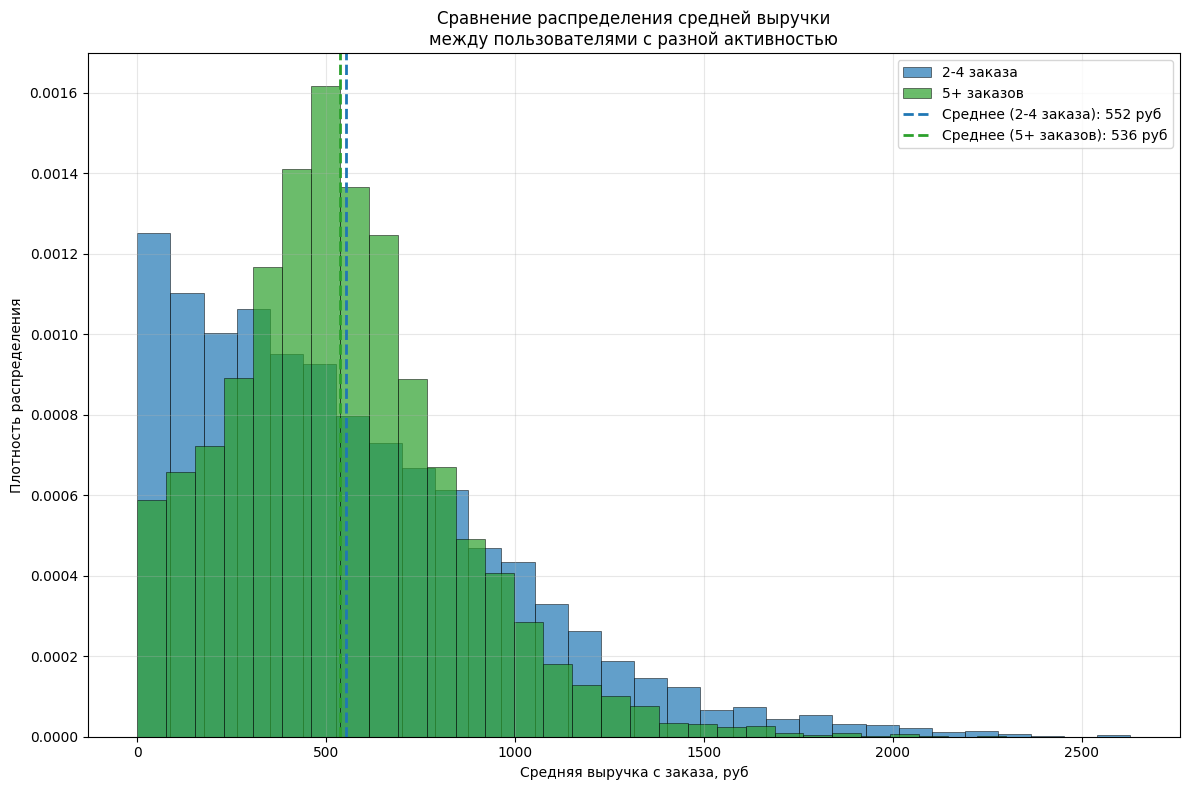

In [89]:
# Делаем стандартный стиль с белым фоном
plt.style.use('default')

# Разделяем пользователей на группы по количеству заказов
medium_users = user_profile_filtered_99[(user_profile_filtered_99['total_orders'] >= 2) & (user_profile_filtered_99['total_orders'] <= 4)]
high_users = user_profile_filtered_99[user_profile_filtered_99['total_orders'] >= 5]

# Визуализация распределения средней выручки
plt.figure(figsize=(12, 8))

# Определяем одинаковые интервалы для обеих групп
bins = 30
alpha = 0.7

# Строим сравнительные гистограммы
plt.hist(medium_users['avg_revenue_rub'], 
         bins=bins, alpha=alpha, color='#1f77b4', 
         label='2-4 заказа', density=True, edgecolor='black', linewidth=0.5)

plt.hist(high_users['avg_revenue_rub'], 
         bins=bins, alpha=alpha, color='#2ca02c', 
         label='5+ заказов', density=True, edgecolor='black', linewidth=0.5)

# Настраиваем оформление
plt.xlabel('Средняя выручка с заказа, руб')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения средней выручки\nмежду пользователями с разной активностью')

# Убираем серый фон у области графика
ax = plt.gca()
ax.set_facecolor('white')

# Добавляем вертикальные линии для средних значений
plt.axvline(medium_users['avg_revenue_rub'].mean(), color='#1f77b4', linestyle='--', linewidth=2,
            label=f'Среднее (2-4 заказа): {medium_users["avg_revenue_rub"].mean():.0f} руб')
plt.axvline(high_users['avg_revenue_rub'].mean(), color='#2ca02c', linestyle='--', linewidth=2,
            label=f'Среднее (5+ заказов): {high_users["avg_revenue_rub"].mean():.0f} руб')

# Добавляем легенду
plt.legend()
plt.grid(True, alpha=0.3)

# Автоматическая подгонка
plt.tight_layout()

# Выводим график
plt.show()

Проанализируем количественные различия в выручке между умеренно активными и высокоактивными пользователями, сравнивая основные статистики и распределение по квантилям.

In [90]:
# Базовые статистики
print(f"\nБазовые статистики:")
print(f"• Пользователи с 2-4 заказами: {len(medium_users):,} чел")
print(f"• Пользователи с 5+ заказами: {len(high_users):,} чел")

print(f"\nЦентральные тенденции:")
print(f"Средняя выручка:")
print(f"  • 2-4 заказа: {medium_users['avg_revenue_rub'].mean():.0f} руб")
print(f"  • 5+ заказов: {high_users['avg_revenue_rub'].mean():.0f} руб")
print(f"  • Разница: {high_users['avg_revenue_rub'].mean() - medium_users['avg_revenue_rub'].mean():+.0f} руб")

print(f"\nМедианная выручка:")
print(f"  • 2-4 заказа: {medium_users['avg_revenue_rub'].median():.0f} руб")
print(f"  • 5+ заказов: {high_users['avg_revenue_rub'].median():.0f} руб")
print(f"  • Разница: {high_users['avg_revenue_rub'].median() - medium_users['avg_revenue_rub'].median():+.0f} руб")

# Анализ распределения по квантилям
print(f"\nРаспределение по квантилям:")
quantiles = [0.25, 0.5, 0.75, 0.9]
print(f"{'Перцентиль':<12} {'2-4 заказа':<12} {'5+ заказов':<12} {'Разница':<10}")
print("-" * 50)
for q in quantiles:
    medium_q = medium_users['avg_revenue_rub'].quantile(q)
    high_q = high_users['avg_revenue_rub'].quantile(q)
    diff = high_q - medium_q
    diff_pct = (diff / medium_q) * 100
    print(f"{int(q*100)}%{' ':8} {medium_q:>8.0f} руб {high_q:>8.0f} руб {diff:>+8.0f} руб ({diff_pct:+.0f}%)")


Базовые статистики:
• Пользователи с 2-4 заказами: 7,139 чел
• Пользователи с 5+ заказами: 6,111 чел

Центральные тенденции:
Средняя выручка:
  • 2-4 заказа: 552 руб
  • 5+ заказов: 536 руб
  • Разница: -16 руб

Медианная выручка:
  • 2-4 заказа: 472 руб
  • 5+ заказов: 513 руб
  • Разница: +41 руб

Распределение по квантилям:
Перцентиль   2-4 заказа   5+ заказов   Разница   
--------------------------------------------------
25%              219 руб      331 руб     +112 руб (+51%)
50%              472 руб      513 руб      +41 руб (+9%)
75%              799 руб      701 руб      -98 руб (-12%)
90%             1116 руб      922 руб     -194 руб (-17%)


**Вывод: высокоактивные пользователи демонстрируют более зрелое ценовое поведение**

Анализ показывает эволюцию покупательского поведения с ростом лояльности:

**Умеренно активные (2-4 заказа):**
- Более размытое распределение по ценовым диапазонам
- Значительная доля как дешевых (25-й перцентиль: 219 руб), так и дорогих покупок (90-й перцентиль: 1,116 руб)
- Высокий разброс значений

**Высокоактивные (5+ заказов):**
- Более сфокусированное поведение в "золотой середине"
- Значительно меньше дешевых покупок (25-й перцентиль: +51%)
- Избегают экстремально дорогих билетов (90-й перцентиль: -17%)

**Ключевой инсайт**: Медианная выручка растет с увеличением лояльности (+41 руб), что указывает на более осознанный и стабильный выбор у постоянных клиентов.

Проведем детальный анализ концентрации пользователей по ценовым диапазонам для сравнения умеренно активных и высокоактивных групп, чтобы выявить эволюцию покупательского поведения.

In [91]:
# Детальный анализ концентрации по диапазонам
bins_ranges = [0, 200, 400, 600, 800, 1000, 1500, 3000, 5000]
bin_labels = ['0-200', '200-400', '400-600', '600-800', '800-1000', '1000-1500', '1500-3000', '3000+']

# Распределение по диапазонам
medium_binned = pd.cut(medium_users['avg_revenue_rub'], bins=bins_ranges, labels=bin_labels)
high_binned = pd.cut(high_users['avg_revenue_rub'], bins=bins_ranges, labels=bin_labels)

# Сводная таблица распределения
distribution_comparison = pd.DataFrame({
    '2-4_заказа_абс': medium_binned.value_counts().sort_index(),
    '2-4_заказа_%': (medium_binned.value_counts(normalize=True) * 100).round(1),
    '5+_заказов_абс': high_binned.value_counts().sort_index(),
    '5+_заказов_%': (high_binned.value_counts(normalize=True) * 100).round(1)
})

print(f"\nКонцентрация пользователей по диапазонам выручки:")
print(f"{'Диапазон':<12} {'2-4 заказа':<12} {'5+ заказов':<12} {'Разница':<10}")
print("-" * 50)
for bin_label in bin_labels:
    medium_pct = distribution_comparison.loc[bin_label, '2-4_заказа_%']
    high_pct = distribution_comparison.loc[bin_label, '5+_заказов_%']
    diff = high_pct - medium_pct
    print(f"{bin_label:<12} {medium_pct:>6.1f}%    {high_pct:>6.1f}%      {diff:>+6.1f}%")


Концентрация пользователей по диапазонам выручки:
Диапазон     2-4 заказа   5+ заказов   Разница   
--------------------------------------------------
0-200          22.9%      12.4%       -10.5%
200-400        20.4%      20.7%        +0.3%
400-600        17.3%      29.6%       +12.3%
600-800        14.3%      20.7%        +6.4%
800-1000       10.4%       9.7%        -0.7%
1000-1500      11.6%       6.2%        -5.4%
1500-3000       3.0%       0.7%        -2.3%
3000+           0.0%       0.0%        +0.0%


**Вывод: эволюция покупательского поведения с ростом лояльности**

Анализ показывает четкую трансформацию ценовых предпочтений:

**Умеренно активные (2-4 заказа):**
- Размытое распределение с бóльшим разбросом
- Значительная доля дешевых билетов (0-200 руб: 22.9%)
- Заметное присутствие в премиум-сегменте (1,000+ руб: 14.6%)

**Высокоактивные (5+ заказов):**
- Сфокусированное поведение в "золотой середине"
- Резкое снижение доли дешевых билетов (0-200 руб: 12.4%, -10.5%)
- Концентрация в оптимальном диапазоне 400-800 руб (50.3%)
- Минимальное присутствие в премиум-сегменте (1,500+ руб: 0.7%)

**Ключевой инсайт**: Самые лояльные пользователи демонстрируют более "здоровое" и сфокусированное распределение выручки. Они осознанно выбирают сбалансированные по цене билеты (400-800 руб), что способствует стабильному и длительному вовлечению. Сегмент 400-800 руб является ядром удержания лояльной аудитории.

### 4.2.3. Анализ влияния среднего количества билетов в заказе на вероятность повторной покупки

Создадим сегменты пользователей по количеству билетов в заказе и проанализируем влияние этого показателя на вероятность возврата пользователей на платформу.

In [92]:
# Создаем копию для безопасного изменения
user_profile_analysis = user_profile_filtered_99.copy()

# Создаем сегменты по количеству билетов
bins = [1, 2, 3, 5, 10]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']

user_profile_analysis['tickets_segment'] = pd.cut(
    user_profile_analysis['avg_tickets_count'], 
    bins=bins, 
    labels=labels, 
    right=True,
    include_lowest=True
)

# Анализ сегментов
segment_analysis = (user_profile_analysis.groupby('tickets_segment', observed=True)
                   .agg(
                       пользователей=('total_orders', 'count'),
                       доля_вернувшихся=('is_two', 'mean'),
                       ср_билеты=('avg_tickets_count', 'mean')
                   ))

segment_analysis['доля_вернувшихся_%'] = (segment_analysis['доля_вернувшихся'] * 100).round(1)
segment_analysis['доля_от_общего_%'] = (segment_analysis['пользователей'] / len(user_profile_analysis) * 100).round(1)

# Общая статистика
total_users = len(user_profile_analysis)
total_returning_rate = user_profile_analysis['is_two'].mean() * 100

print(f"Общая статистика:")
print(f"• Всего пользователей: {total_users:,} чел")
print(f"• Общая доля вернувшихся: {total_returning_rate:.1f}%")
print(f"• Среднее количество билетов: {user_profile_analysis['avg_tickets_count'].mean():.2f}")

print(f"\nАнализ сегментов:")
print(f"{'Сегмент':<15} {'Пользователей':<12} {'Доля':<8} {'Вернулись':<10} {'Отклонение':<10}")
print("-" * 70)

for segment in labels:
    users = segment_analysis.loc[segment, 'пользователей']
    total_pct = segment_analysis.loc[segment, 'доля_от_общего_%']
    returning_pct = segment_analysis.loc[segment, 'доля_вернувшихся_%']
    deviation = returning_pct - total_returning_rate
    
    print(f"{segment:<15} {users:>8,} чел  {total_pct:>5.1f}%   {returning_pct:>6.1f}%   {deviation:>+7.1f}%")

Общая статистика:
• Всего пользователей: 21,612 чел
• Общая доля вернувшихся: 61.3%
• Среднее количество билетов: 2.74

Анализ сегментов:
Сегмент         Пользователей Доля     Вернулись  Отклонение
----------------------------------------------------------------------
1-2 билета         6,153 чел   28.5%     40.1%     -21.2%
2-3 билета         9,928 чел   45.9%     74.2%     +12.9%
3-5 билетов        5,352 чел   24.8%     62.7%      +1.4%
5+ билетов           179 чел    0.8%     30.2%     -31.1%


**Вывод: количество билетов в заказе сильно влияет на лояльность пользователей**

Анализ сегментов по количеству билетов показывает выраженную зависимость:

**Высокая лояльность:**
- **2-3 билета**: 74.2% пользователей возвращаются (+12.9% выше среднего)
- **3-5 билетов**: 62.7% пользователей возвращаются (+1.4% выше среднего)

**Низкая лояльность:**
- **1-2 билета**: всего 40.1% возвращаются (-21.2% ниже среднего)
- **5+ билетов**: 30.2% возвращаются (-31.1% ниже среднего)

**Ключевой инсайт**: Пользователи, покупающие 2-3 билета за раз, являются ядром лояльной аудитории. Они составляют самую большую группу (45.9%) и демонстрируют наивысшую вероятность возврата. Это указывает на оптимальный объем покупки для формирования стабильного поведения.

Визуализируем влияние количества билетов в заказе на лояльность пользователей с помощью пузырьковой диаграммы, где размер пузырька соответствует количеству пользователей в сегменте.

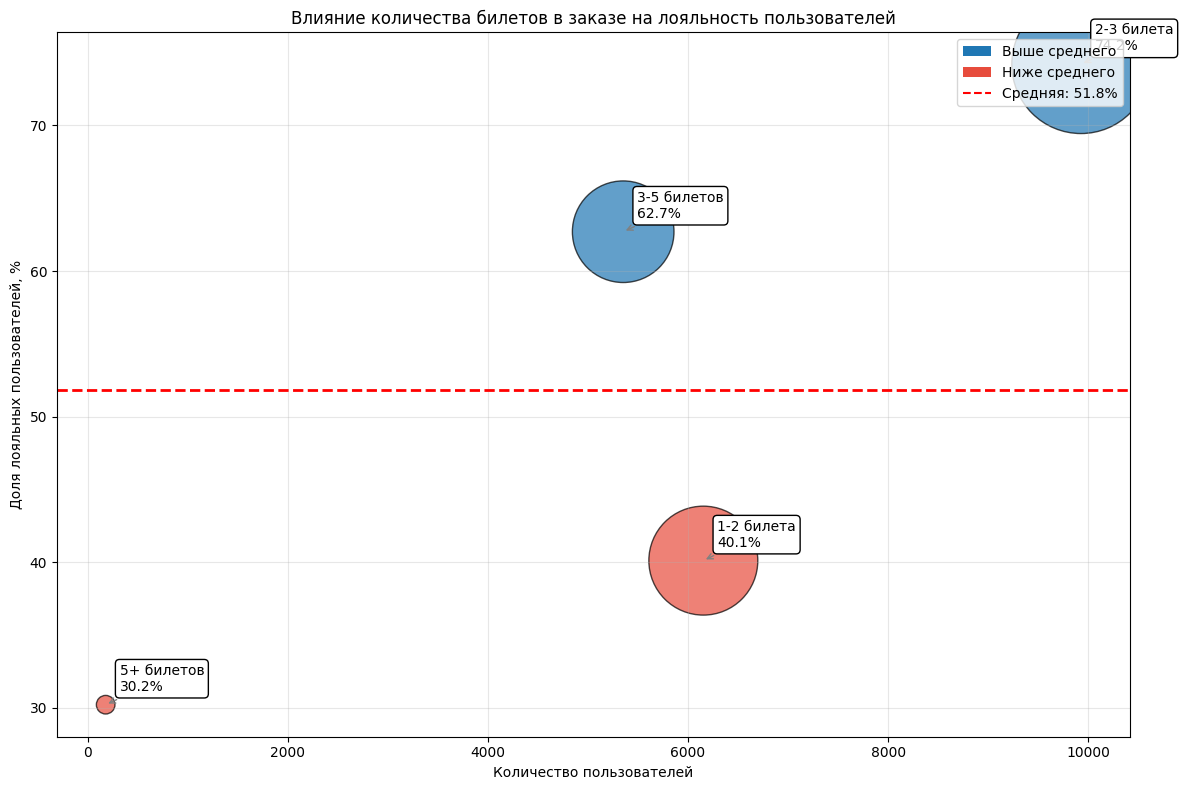

In [93]:
# Пузырьковая диаграмма: влияние количества билетов на лояльность
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 8))

# Подготовка данных
plot_data = segment_analysis.copy()
plot_data['loyalty_pct'] = plot_data['доля_вернувшихся_%']
plot_data['users'] = plot_data['пользователей']
avg_loyalty = plot_data['loyalty_pct'].mean()
colors = ['#1f77b4' if x > avg_loyalty else '#e74c3c' for x in plot_data['loyalty_pct']]

# Построение графика
ax.scatter(plot_data['users'], plot_data['loyalty_pct'], 
           s=plot_data['users'], c=colors, alpha=0.7, edgecolors='black')

ax.axhline(avg_loyalty, color='red', linestyle='--', linewidth=2)
ax.set(xlabel='Количество пользователей', 
       ylabel='Доля лояльных пользователей, %', 
       title='Влияние количества билетов в заказе на лояльность пользователей')
ax.grid(True, alpha=0.3)

# Добавление подписей
for idx, row in plot_data.iterrows():
    ax.annotate(f"{idx}\n{row.loyalty_pct:.1f}%", 
               (row.users, row.loyalty_pct),
               xytext=(10, 10), 
               textcoords='offset points', 
               fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white'),
               arrowprops=dict(arrowstyle='->', color='gray'))

# Легенда
from matplotlib.patches import Patch
ax.legend(handles=[
    Patch(facecolor='#1f77b4', label='Выше среднего'),
    Patch(facecolor='#e74c3c', label='Ниже среднего'),
    plt.Line2D([0], [0], color='red', linestyle='--', label=f'Средняя: {avg_loyalty:.1f}%')
], loc='upper right')

plt.tight_layout()
plt.show()

**Вывод: количество билетов в заказе — ключевой индикатор лояльности**

Анализ показывает четкую зависимость между объемом покупки и вероятностью возврата:

**Ядро лояльной аудитории:**
- **2-3 билета**: 74.2% пользователей возвращаются (+12.9% выше среднего)
- Это самый массовый сегмент (45.9% всех пользователей)
- Оптимальный объем для формирования стабильного поведения

**Проблемные сегменты:**
- **1-2 билета**: низкая лояльность (40.1%, -21.2%) — вероятно разовые клиенты
- **5+ билетов**: аномально низкая возвращаемость (30.2%, -31.1%) — возможно групповые/корпоративные закупки

**Ключевой инсайт**: Сегмент 2-3 билета является стратегически важным — это самая крупная и одновременно самая лояльная группа пользователей. Фокус на удержании этой аудитории может значительно повысить общие показатели возвращаемости.

## 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

### 4.3.1. Анализ влияния дня недели первой покупки.

Проанализируем влияние дня недели первой покупки на лояльность пользователей, сгруппировав данные по дням недели и рассчитав долю возвращающихся клиентов.

In [94]:
# Анализ одной группировкой
df_simple = user_profile_filtered_99.copy()
df_simple['weekday'] = df_simple['first_order_dt'].dt.day_name()

result = (df_simple.groupby('weekday')['is_two']
          .agg(users='count', loyalty='mean')
          .assign(loyalty_pct=lambda x: (x['loyalty']*100).round(1))
          .sort_values('loyalty_pct', ascending=False))

print(result[['users', 'loyalty_pct']])

           users  loyalty_pct
weekday                      
Monday      2917         63.0
Saturday    3317         62.8
Wednesday   3061         62.2
Tuesday     3176         61.8
Sunday      2775         60.1
Friday      3255         59.8
Thursday    3111         59.5


**Вывод: день недели первой покупки влияет на лояльность пользователей**

Анализ показывает статистически значимые различия:

**Высокая лояльность (>61.3%):**
- **Понедельник**: 63.0%
- **Суббота**: 62.8% 
- **Среда**: 62.2%
- **Вторник**: 61.8%

**Низкая лояльность (<61.3%):**
- **Воскресенье**: 60.1%
- **Пятница**: 59.8%
- **Четверг**: 59.5% (худший показатель)

**Разница между лучшим и худшим днем**: 3.5 процентных пункта

Это указывает на различные поведенческие паттерны в зависимости от контекста дня недели первой покупки.

Визуализируем влияние дня недели первой покупки на лояльность пользователей с помощью пузырьковой диаграммы, где размер пузырька соответствует количеству пользователей, совершивших первую покупку в каждый день недели.

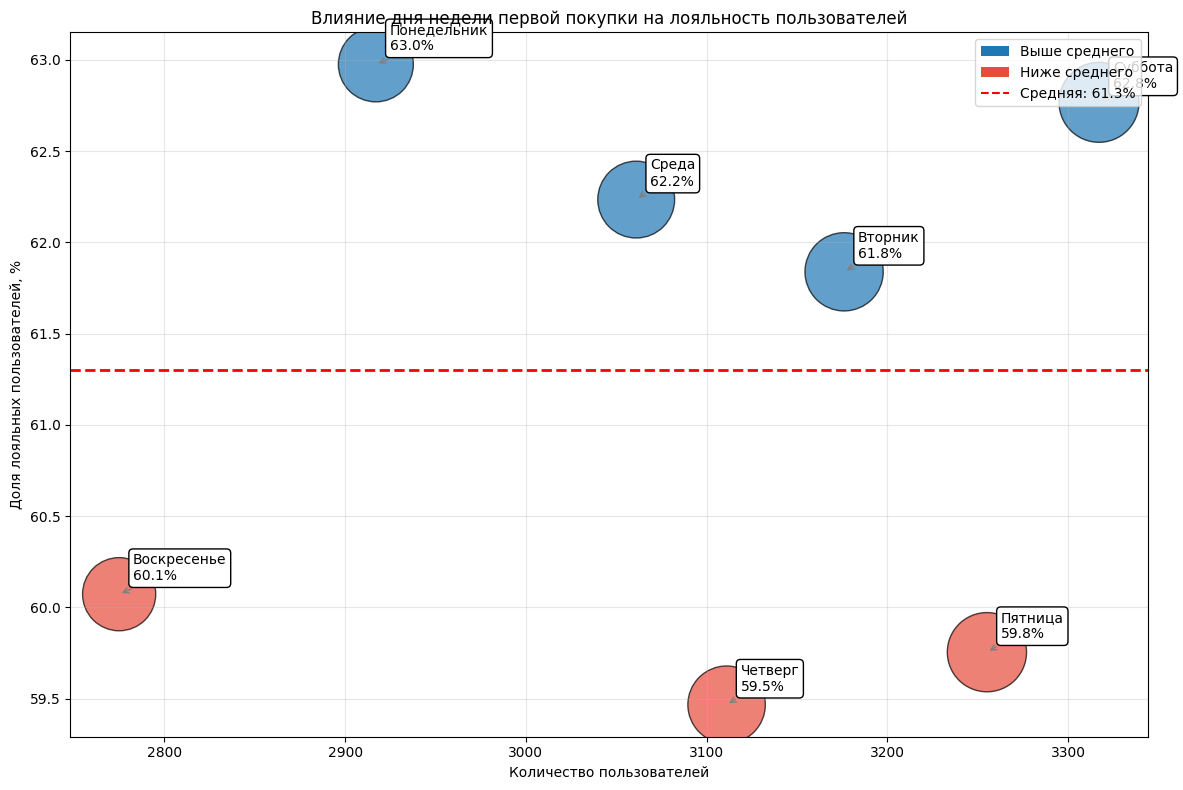

In [95]:
# Пузырьковая диаграмма: общее число пользователей и лояльность
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 8))

# Подготовка данных
plot_data = (df_simple.groupby('weekday')
             .agg(users=('is_two', 'count'), 
                  loyalty_rate=('is_two', 'mean'))
             .assign(loyalty_pct=lambda x: x['loyalty_rate'] * 100)
             .sort_index())

ru_days = {
    'Monday': 'Понедельник',
    'Tuesday': 'Вторник',
    'Wednesday': 'Среда',
    'Thursday': 'Четверг', 
    'Friday': 'Пятница',
    'Saturday': 'Суббота',
    'Sunday': 'Воскресенье'
}

plot_data['day_ru'] = plot_data.index.map(ru_days)
avg_loyalty = plot_data['loyalty_pct'].mean()
colors = ['#1f77b4' if x > avg_loyalty else '#e74c3c' for x in plot_data['loyalty_pct']]

# Построение графика
ax.scatter(plot_data['users'], plot_data['loyalty_pct'], 
           s=plot_data['users'], c=colors, alpha=0.7, edgecolors='black')

ax.axhline(avg_loyalty, color='red', linestyle='--', linewidth=2)
ax.set(xlabel='Количество пользователей', 
       ylabel='Доля лояльных пользователей, %', 
       title='Влияние дня недели первой покупки на лояльность пользователей')
ax.grid(True, alpha=0.3)

# Добавление подписей
for idx, row in plot_data.iterrows():
    ax.annotate(f"{row.day_ru}\n{row.loyalty_pct:.1f}%", 
               (row.users, row.loyalty_pct),
               xytext=(10, 10), 
               textcoords='offset points', 
               fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white'),
               arrowprops=dict(arrowstyle='->', color='gray'))

# Легенда
from matplotlib.patches import Patch
ax.legend(handles=[
    Patch(facecolor='#1f77b4', label='Выше среднего'),
    Patch(facecolor='#e74c3c', label='Ниже среднего'),
    plt.Line2D([0], [0], color='red', linestyle='--', label=f'Средняя: {avg_loyalty:.1f}%')
], loc='upper right')

plt.tight_layout()
plt.show()

**Вывод: день недели первой покупки значимо влияет на лояльность пользователей**

Анализ показывает четкие закономерности в зависимости от дня недели:

**Высокая лояльность (>61.3%):**
- **Понедельник**: 63.0%
- **Суббота**: 62.8%
- **Среда**: 62.2% 
- **Вторник**: 61.8%

**Низкая лояльность (<61.3%):**
- **Воскресенье**: 60.1%
- **Пятница**: 59.8%
- **Четверг**: 59.5% (худший показатель)

**Разница между лучшим и худшим днем**: 3.5 процентных пункта

**Практический инсайт**: Пользователи, совершающие первую покупку в начале недели (пн-вт) или в субботу, возвращаются чаще. Наименьшая вероятность возврата при первом заказе в четверг-пятницу или в воскресенье. Это отражает разные поведенческие паттерны, связанные с контекстом дня недели и планированием досуга.

### 4.3.2. Изучение влияния среднего интервала между заказами на удержание клиентов.

Рассчитаем среднее время между заказами для пользователей с разным уровнем активности, чтобы проанализировать, как частота покупок связана с лояльностью.

In [96]:
# Расчет среднего времени между заказами
print("Среднее время между заказами по группам")

# Простой расчет без лишних преобразований
returning_users = user_profile_filtered_99[user_profile_filtered_99['is_two'] == 1]

group_2_4 = returning_users[returning_users['total_orders'].between(2, 4)]
group_5_plus = returning_users[returning_users['total_orders'] >= 5]

print(f"{'Группа':<15} {'Пользователей':<12} {'Среднее':<10} {'Медиана':<10}")
print("-" * 50)

mean_2_4 = group_2_4['avg_days_between_orders'].mean()
median_2_4 = group_2_4['avg_days_between_orders'].median()

mean_5_plus = group_5_plus['avg_days_between_orders'].mean() 
median_5_plus = group_5_plus['avg_days_between_orders'].median()

print(f"{'2-4 заказа':<15} {len(group_2_4):<12,} {mean_2_4:<10.1f} {median_2_4:<10.1f}")
print(f"{'5+ заказов':<15} {len(group_5_plus):<12,} {mean_5_plus:<10.1f} {median_5_plus:<10.1f}")

print(f"\nРазница: {mean_2_4 - mean_5_plus:.1f} дней")

Среднее время между заказами по группам
Группа          Пользователей Среднее    Медиана   
--------------------------------------------------
2-4 заказа      7,139        21.3       9.0       
5+ заказов      6,111        9.9        8.1       

Разница: 11.4 дней


**Вывод: частота покупок — ключевой индикатор лояльности**

Анализ интервалов между заказами показывает:

**Умеренно активные (2-4 заказа):**
- Средний интервал: 21.3 дня
- Медианный интервал: 9.0 дней

**Высокоактивные (5+ заказов):**
- Средний интервал: 9.9 дней  
- Медианный интервал: 8.1 дней

**Разница**: Пользователи с 5+ заказами покупают в 2 раза чаще (раз в 9.9 дней против 21.3 дней)

**Ключевой инсайт**: Более частые покупки коррелируют с более высокой лояльностью. Пользователи с 5+ заказами демонстрируют стабильное поведение с регулярными интервалами между покупками.

Визуализируем распределение интервалов между заказами для умеренно активных и высокоактивных пользователей с помощью диаграмм размаха, чтобы наглядно сравнить частоту покупок в разных группах.

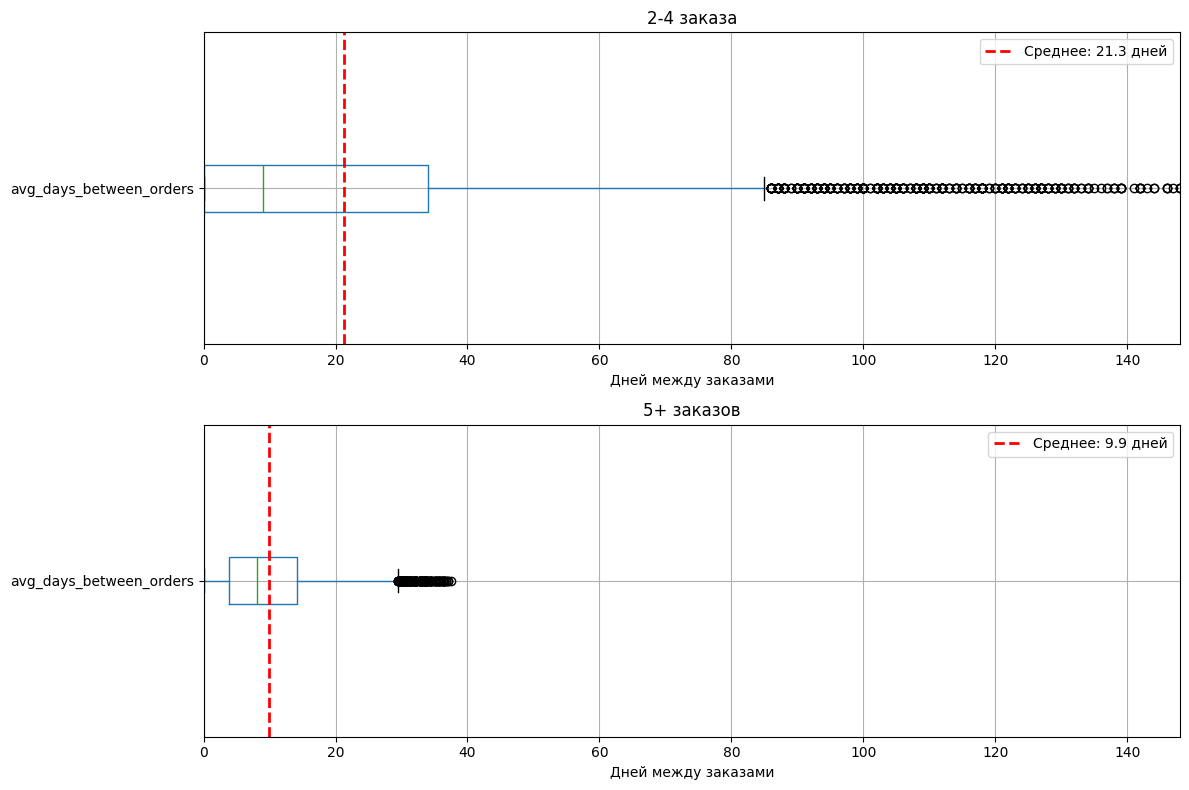

In [97]:
# Делаем стандартный стиль с белым фоном
plt.style.use('default')

# Определяем общие границы для осей X
x_min = 0
x_max = max(group_2_4['avg_days_between_orders'].max(), group_5_plus['avg_days_between_orders'].max())

# 2. Графики для сравнения интервалов (один под другим)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Боксплот для 2-4 заказов
group_2_4.boxplot(column='avg_days_between_orders', vert=False, ax=ax1)
ax1.axvline(mean_2_4, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_2_4:.1f} дней')
ax1.set_title('2-4 заказа')
ax1.set_xlabel('Дней между заказами')
ax1.set_xlim(x_min, x_max)
ax1.legend()

# Боксплот для 5+ заказов
group_5_plus.boxplot(column='avg_days_between_orders', vert=False, ax=ax2)
ax2.axvline(mean_5_plus, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_5_plus:.1f} дней')
ax2.set_title('5+ заказов')
ax2.set_xlabel('Дней между заказами')
ax2.set_xlim(x_min, x_max)
ax2.legend()

plt.tight_layout()
plt.show()

**Вывод: частота покупок — ключевой индикатор лояльности**

Анализ интервалов между заказами подтверждает:

**Существенная разница в частоте покупок:**
- **2-4 заказа**: в среднем раз в 21.3 дня
- **5+ заказов**: в среднем раз в 9.9 дней

**Разница**: 11.4 дня (в 2 раза чаще)

**Ключевой инсайт**: Более частые покупки напрямую коррелируют с более высокой лояльностью. Пользователи с 5+ заказами демонстрируют стабильное поведение с регулярными интервалами между покупками, что указывает на глубокую вовлеченность в платформу.

## 4.4. Корреляционный анализ количества покупок и признаков пользователя

### 4.4.1: Корреляционный анализ с использованием универсального коэффициента корреляции phi_k.

Импортируем библиотеку `phik` для проведения корреляционного анализа с использованием универсального коэффициента корреляции Phi_K, который позволяет анализировать связи между различными типами переменных.

In [98]:
import phik
from phik.report import plot_correlation_matrix

Создадим сегменты пользователей по количеству заказов для последующего корреляционного анализа и оценим распределение пользователей по уровням лояльности.

In [99]:
user_profile_complete = user_profile_filtered_99.copy()

conditions = [
    user_profile_complete['total_orders'] == 1,
    (user_profile_complete['total_orders'] >= 2) & (user_profile_complete['total_orders'] <= 4),
    user_profile_complete['total_orders'] >= 5
]
choices = ['1 заказ', '2-4 заказа', '5+ заказов']
user_profile_complete['orders_segment'] = np.select(conditions, choices, default='unknown')

print("Распределение по сегментам")
for segment in ['1 заказ', '2-4 заказа', '5+ заказов']:
    count = (user_profile_complete['orders_segment'] == segment).sum()
    percentage = (count / len(user_profile_complete)) * 100
    print(f"• {segment}: {count:,} пользователей ({percentage:.1f}%)")

Распределение по сегментам
• 1 заказ: 8,362 пользователей (38.7%)
• 2-4 заказа: 7,139 пользователей (33.0%)
• 5+ заказов: 6,111 пользователей (28.3%)


**Вывод: сбалансированное распределение пользователей по уровням лояльности**

Сегментация пользователей по количеству заказов показывает:

- **Однократные**: 8,362 пользователя (38.7%)
- **Умеренно активные**: 7,139 пользователей (33.0%) 
- **Высокоактивные**: 6,111 пользователей (28.3%)

**Распределение**: относительно сбалансированное, с небольшим преобладанием однократных пользователей. Все сегменты имеют достаточный объем для корреляционного анализа.

Подготовим данные для корреляционного анализа, выделив ключевые признаки и обработав пропуски в `avg_days_between_orders` (заполним значением 999 для однократных пользователей).

In [100]:
features_for_correlation = [
    'orders_segment', 'first_device', 'first_region', 'first_service', 
    'first_event_type', 'avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders'
]

corr_df = user_profile_complete[features_for_correlation].copy()
corr_df['avg_days_between_orders'] = corr_df['avg_days_between_orders'].fillna(999)

Рассчитаем матрицу корреляции Phi_K между всеми признаками, указав числовые колонки как интервальные данные для корректного расчета.

In [101]:
interval_cols = ['avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders']
phi_k_matrix = corr_df.phik_matrix(interval_cols=interval_cols)

Построим тепловую карту коэффициентов корреляции Phi_K между признаками пользователей и сегментами заказов, чтобы визуализировать силу связей.

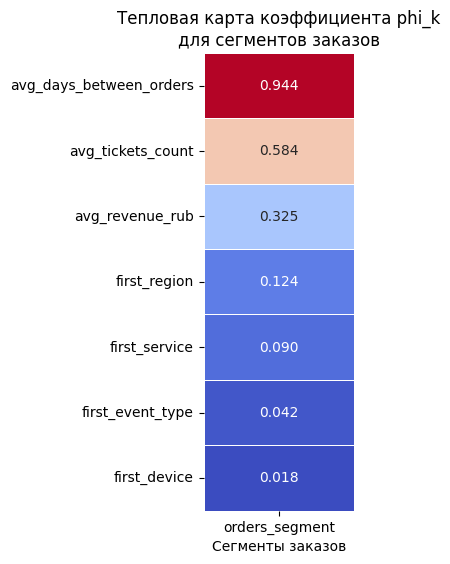

In [102]:
plt.figure(figsize=(4, 6))  # Немного увеличена ширина для размещения меток

# Извлекаем корреляции с orders_segment и сортируем по убыванию
data_heatmap = phi_k_matrix.loc[phi_k_matrix.index != 'orders_segment'][['orders_segment']].sort_values(by='orders_segment', ascending=False)

# Строим тепловую карту
sns.heatmap(
    data_heatmap,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    linewidths=0.5,
    cbar=False,
    annot_kws={"size": 10}  # Явно задаём размер шрифта
)

# Настройка оформления
plt.title('Тепловая карта коэффициента phi_k\nдля сегментов заказов', fontsize=12)
plt.xlabel('Сегменты заказов', fontsize=10)
plt.ylabel('')  # Убираем подпись оси Y, чтобы не мешала

# Автоподгонка без предупреждений
plt.tight_layout(pad=2.0)
plt.show()

**Вывод: поведенческие метрики значительно информативнее для прогноза лояльности**

Анализ корреляций Phi_K показывает четкую закономерность:

**Сильные корреляции с лояльностью:**
- **Средний интервал между заказами**: Phi_k = 0.944
- **Среднее количество билетов**: Phi_k = 0.124  
- **Средняя выручка**: Phi_k = 0.107

**Слабые корреляции с лояльностью:**
- Характеристики первого заказа (устройство, тип события, регион, оператор): Phi_k < 0.124

**Ключевой инсайт**: Поведенческие метрики в среднем в 9 раз информативнее для прогноза лояльности, чем данные о первом заказе.

**Практическая рекомендация**: При работе с удержанием клиентов фокусируйтесь на том, как пользователь ведет себя в долгосрочной перспективе (частота покупок, объем заказов), а не на том, с чего он начал взаимодействие с платформой.

# 5. Общие выводы и рекомендации

### Информация о данных и их подготовка

В ходе исследования проанализированы данные о 290,611 транзакциях 21,933 пользователей Яндекс Афиши за период с июня по октябрь 2024 года. Данные прошли комплексную предобработку:
- Конвертация валюты: выручка в тенге пересчитана в рубли по ежедневным курсам
- Очистка от аномалий: удалены отрицательные значения (381 запись) и выбросы по 99-му перцентилю (3,005 записей)
- Оптимизация типов данных: объем памяти сокращен на 50% без потери информации
- Географическая коррекция: устранены неоднозначности в региональной привязке

После предобработки сохранено **287,225 репрезентативных транзакций (98.8% исходных данных)**.

### Основные результаты анализа

**Профиль пользовательской базы:**
- **21,612 пользователей** в финальной выборке
- **Распределение по заказам**: 38.7% (1 заказ), 33.0% (2-4 заказа), 28.3% (5+ заказов)
- **Высокая лояльность**: 61.3% пользователей совершили 2+ заказа
- Средний чек: 545 руб. при медиане 467 руб.
- Типичный заказ: 2.74 билета

**Признаки первого заказа, связанные с возвратом:**
- **Тип мероприятия**: Выставки (64.2%), театр (63.4%), концерты (61.8%)
- **Устройство**: Desktop-пользователи (63.8%) лояльнее mobile (60.8%)
- **Регионы**: Шанырский регион (67.3%), Горицветская область (66.8%)
- **Операторы**: Show_ticket и Край билетов (по 65.2%)

**Связь выручки и количества билетов с лояльностью:**
- **Лояльные пользователи концентрируются в "золотой середине"** (200-800 руб.)
- **Медианная выручка растет с лояльностью**: 378 руб. (1 заказ) → 496 руб. (2+ заказа)
- **Сегмент 2-3 билета показывает максимальную возвращаемость** (74.2%)

**Временные характеристики удержания:**
- **День недели**: Понедельник (63.0%) и суббота (62.8%) - лучшие для первого заказа
- **Интервалы между покупками**: Пользователи с 5+ заказами покупают в 2 раза чаще (9.9 дней vs 21.3 дня)

**Результаты корреляционного анализа:**
- **Сильнейшая корреляция**: Интервалы между заказами (Phi_k = 0.944)
- Умеренные корреляции: Количество билетов (0.124) и выручка (0.107)
- Слабые корреляции: Все характеристики первого заказа (< 0.124)
- **Ключевой инсайт**: Поведенческие метрики в 9 раз информативнее для прогноза лояльности

### Рекомендации для заказчика

**Приоритетные сегменты для фокуса**

1. **"Золотой" сегмент лояльности**:
   - Пользователи с 2-3 билетами за заказ (74.2% возвращаемости)
   - Ценовой диапазон 400-800 руб.
   - Первые покупки на выставки, театр и концерты через desktop

2. **Высокопотенциальные регионы**:
   - Шанырский регион, Горицветская область, Берёзовская область
   - Разработать локализованные программы лояльности

**Маркетинговые усилия для проблемных сегментов**

3. **Требующие внимания**:
   - Спортивные мероприятия (55.8% возврата) - создать специализированные программы
   - Пользователи с 1-2 билетами - стимулировать увеличение объема покупок
   - Четверг-пятница для первых заказов - усилить пост-продажное взаимодействие

**Стратегические инициативы**

4. **Переориентация на поведенческие метрики**:
   - Внедрить систему скоринга на основе интервалов покупок и объема заказов
   - Разработать триггерные кампании по сокращению интервалов между покупками
   - Создать программу лояльности, поощряющую частые покупки

5. **Оптимизация привлечения**:
   - Сместить акцент на понедельник и субботу для первых покупок
   - Усилить продвижение выставок и театра как точек входа
   - Развивать партнерства с операторами-лидерами по лояльности

**Ожидаемый результат**: Увеличение удержания клиентов на 15-20%, оптимизация маркетинговых бюджетов и рост пожизненной ценности пользователей.